<a href="https://colab.research.google.com/github/JulesPeRiSo8/SYS819/blob/main/SYS819.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet sentiment analysis

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("goddiao/stockemotions")

print("Path to dataset files:", path)

100%|██████████| 3.71M/3.71M [00:00<00:00, 87.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/goddiao/stockemotions/versions/1


In [ ]:
import os

tweet_path = os.path.join(path, "tweet")
os.listdir(tweet_path)

['train_stockemo.csv',
 'test_stockemo.csv',
 'processed_stockemo.csv',
 'val_stockemo.csv']

In [ ]:
import pandas as pd

train_df = pd.read_csv(os.path.join(tweet_path, "train_stockemo.csv"))
val_df = pd.read_csv(os.path.join(tweet_path, "val_stockemo.csv"))
test_df = pd.read_csv(os.path.join(tweet_path, "test_stockemo.csv"))

In [ ]:
# Group all the df in a list to make the same changes to all of them
stock_emotion_df = pd.concat([train_df, val_df, test_df])
stock_emotion_df.shape

(10000, 7)

In [ ]:
stock_emotion_df.head()

,id,date,ticker,emo_label,senti_label,original,processed
0,100001,2020-01-01,AMZN,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [...
1,100002,2020-01-01,TSLA,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's t...,Tesla Daddy's drinkin' eArly tonight! Here's t...
2,100003,2020-01-01,AAPL,confusion,bullish,$AAPL We’ll been riding since last December fr...,Apple We’ll been riding since last December fr...
3,100004,2020-01-01,TSLA,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine gla..."
4,100005,2020-01-01,TSLA,excitement,bullish,"$TSLA haha just a collection of greats...""Mars...","Tesla haha just a collection of greats...""Mars..."


In [ ]:
# Remove the "id", "original" and "processed" columns
stock_emotion_df.drop(columns=["id", "original", "processed"], inplace=True)

In [ ]:
stock_emotion_df.head(n=1)

,date,ticker,emo_label,senti_label
0,2020-01-01,AMZN,excitement,bullish


In [ ]:
# Function for the sentiment analysis with VADER

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

def sentiment_analysis(df):
    # create a score with from vader SentimentIntensityAnalyzer
    sentiment_analyzer = SentimentIntensityAnalyzer()
    for index, row in df.iterrows():
        sentence_i = unicodedata.normalize('NFKD', row['emo_label'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        df.loc[index, 'sentiment_score'] = sentence_sentiment['compound']
        df.loc[index, 'Negative'] = sentence_sentiment['neg']
        df.loc[index, 'Neutral'] = sentence_sentiment['neu']
        df.loc[index, 'Positive'] = sentence_sentiment['pos']

    # Map senti_label to binary values
    df['senti_label'] = df['senti_label'].map({'bullish': 1, 'bearish': 0})
    # Remove the emo_label column
    df.drop(columns=['emo_label'], inplace=True)

sentiment_analysis(stock_emotion_df)

stock_emotion_df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,date,ticker,senti_label,sentiment_score,Negative,Neutral,Positive
0,2020-01-01,AMZN,1,-0.2960,1.0,0.0,0.0
1,2020-01-01,TSLA,1,-0.1779,1.0,0.0,0.0
2,2020-01-01,AAPL,1,-0.2960,1.0,0.0,0.0
3,2020-01-01,TSLA,1,-0.2960,1.0,0.0,0.0
4,2020-01-01,TSLA,1,-0.2960,1.0,0.0,0.0


In [ ]:
# Group data by date and ticker and take the mean value
annual_emotion_df = stock_emotion_df.groupby(['date', 'ticker']).mean().reset_index()
annual_emotion_df.head()

,date,ticker,senti_label,sentiment_score,Negative,Neutral,Positive
0,2020-01-01,AAPL,1.0,-0.296000,1.00,0.0,0.00
1,2020-01-01,AMZN,1.0,-0.296000,1.00,0.0,0.00
2,2020-01-01,TSLA,1.0,-0.236950,1.00,0.0,0.00
3,2020-01-02,AAPL,1.0,-0.129138,0.75,0.0,0.25
4,2020-01-02,DIS,1.0,0.542300,0.00,0.0,1.00


# Financial data analysis

To calculate the financial indicators, we need the data from the previous months/years of each stocks. I use the yahoo package to download the financial data of the different stocks from 01/01/2019 to 01/02/2021 as the stockemotion dataset goes from 01/01/2020 to 01/01/2021

In [ ]:
# Check the stock for which there is the most available data

count = annual_emotion_df['ticker'].value_counts()
print(count)

ticker
AAPL     296
TSLA     284
BA       211
AMZN     176
DIS      134
MSFT     134
CCL      115
FB       115
BABA     109
NFLX      98
NVDA      81
WMT       70
PFE       65
BAC       43
SBUX      36
V         36
XOM       35
HD        35
PYPL      33
JPM       25
NKE       21
MCD       21
ABNB      20
JNJ       18
GOOG      17
GOOGL     14
BKNG      13
BRK.B     13
KO        13
UPS       12
TSM       10
LOW       10
MA         8
UNH        6
CVX        3
PG         3
AMT        2
Name: count, dtype: int64


Focus on Apple, Tesla and BA as they have the maximum amount of data

In [ ]:
import yfinance as yf

# Load the financial data of AAPL, TSLA and BA
aapl_stock_price = yf.download('AAPL',
                               start='2019-01-01',
                               end='2021-02-01',
                               interval='1d')
tsla_stock_price = yf.download('TSLA',
                               start='2019-01-01',
                               end='2021-02-01',
                               interval='1d')
ba_stock_price = yf.download('BA',
                               start='2019-01-01',
                               end='2021-02-01',
                               interval='1d')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
aapl_stock_price.shape

(524, 6)

In [ ]:
tsla_stock_price.shape

(524, 6)

In [ ]:
ba_stock_price.shape

(524, 6)

In [ ]:
# Function to add financial indicators to the dataset

def add_financial_indicators(df):

    # Reformate the date as YYYY-MM-DD
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    df.rename(columns={'Date': 'date'}, inplace=True)

    # Replace the MultiIndex columns with the first level
    df.columns = [col[0] for col in df.columns]

    # Calculate EMA over 20 days
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # Calculate RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Calculate MACD (Moving Average Convergence Divergence)
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate Bollinger Bands
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + 2 * rolling_std
    df['Bollinger_Lower'] = rolling_mean - 2 * rolling_std

    # Calculate Stochastic Oscillator
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    df['Stochastic_K'] = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    df['Stochastic_D'] = df['Stochastic_K'].rolling(window=3).mean()

    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    tp_sma = typical_price.rolling(window=20).mean()
    tp_std = typical_price.rolling(window=20).std()
    df['CCI'] = (typical_price - tp_sma) / (0.015 * tp_std)

    # Calculate Momentum
    df['Momentum'] = df['Close'].diff(periods=10)

    return df

In [ ]:
aapl_financial_df = add_financial_indicators(aapl_stock_price)
tsla_financial_df = add_financial_indicators(tsla_stock_price)
ba_financial_df = add_financial_indicators(ba_stock_price)

In [ ]:
aapl_financial_df.head(n=30)

,date,Adj Close,Close,High,Low,Open,Volume,EMA_20,RSI,MACD,Signal_Line,Bollinger_Upper,Bollinger_Lower,Stochastic_K,Stochastic_D,CCI,Momentum
0,2019-01-02,37.708603,39.480000,39.712502,38.557499,38.722500,148158800,39.480000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,33.952549,35.547501,36.430000,35.500000,35.994999,365248800,39.105476,NaN,-0.313704,-0.062741,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,35.401955,37.064999,37.137501,35.950001,36.132500,234428400,38.911145,NaN,-0.434854,-0.137163,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,35.323151,36.982498,37.207500,36.474998,37.174999,219111200,38.727464,NaN,-0.531398,-0.216010,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,35.996525,37.687500,37.955002,37.130001,37.389999,164101200,38.628420,NaN,-0.544742,-0.281757,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-09,36.607800,38.327499,38.632500,37.407501,37.822498,180396400,38.599761,NaN,-0.497935,-0.324992,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-01-10,36.724815,38.450001,38.492500,37.715000,38.125000,143122800,38.585498,NaN,-0.445817,-0.349157,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-01-11,36.364250,38.072498,38.424999,37.877499,38.220001,108092800,38.536641,NaN,-0.430017,-0.365329,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-01-14,35.817444,37.500000,37.817501,37.305000,37.712502,129756800,38.437913,NaN,-0.458407,-0.383945,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-01-15,36.550507,38.267502,38.347500,37.512501,37.567501,114843600,38.421683,NaN,-0.414200,-0.389996,NaN,NaN,NaN,NaN,NaN,NaN


from matplotlib import pyplot as plt
_df_0['Adj Close'].plot(kind='hist', bins=20, title='Adj Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Adj Close', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Close', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Low', y='Open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Adj Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Adj Close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['High']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('High')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Low']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Low')

from matplotlib import pyplot as plt
_df_12['Adj Close'].plot(kind='line', figsize=(8, 4), title='Adj Close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
aapl_financial_df.columns

Index(['date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'EMA_20',
       'RSI', 'MACD', 'Signal_Line', 'Bollinger_Upper', 'Bollinger_Lower',
       'Stochastic_K', 'Stochastic_D', 'CCI', 'Momentum'],
      dtype='object')

In [ ]:
tsla_financial_df.head()

,date,Adj Close,Close,High,Low,Open,Volume,EMA_20,RSI,MACD,Signal_Line,Bollinger_Upper,Bollinger_Lower,Stochastic_K,Stochastic_D,CCI,Momentum
0,2019-01-02,20.674667,20.674667,21.008667,19.920000,20.406668,174879000,20.674667,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,20.024000,20.024000,20.626667,19.825333,20.466667,104478000,20.612699,NaN,-0.051905,-0.010381,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,21.179333,21.179333,21.200001,20.181999,20.400000,110911500,20.666664,NaN,0.000183,-0.008268,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,22.330667,22.330667,22.449333,21.183332,21.448000,113268000,20.825141,NaN,0.132836,0.019953,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,22.356667,22.356667,22.934000,21.801332,22.797333,105127500,20.971000,NaN,0.237326,0.063427,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ba_financial_df.head()

,date,Adj Close,Close,High,Low,Open,Volume,EMA_20,RSI,MACD,Signal_Line,Bollinger_Upper,Bollinger_Lower,Stochastic_K,Stochastic_D,CCI,Momentum
0,2019-01-02,314.645142,323.809998,323.950012,313.709991,316.190002,3292200,323.809998,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,302.100525,310.899994,319.739990,309.399994,319.489990,5705600,322.580473,NaN,-1.029858,-0.205972,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,317.822571,327.079987,328.440002,316.079987,316.690002,4448800,323.008998,NaN,-0.534279,-0.271633,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,318.823425,328.109985,330.690002,323.350006,330.519989,4030300,323.494807,NaN,-0.057750,-0.228856,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,330.891937,340.529999,341.250000,332.649994,334.109985,4736500,325.117206,NaN,1.307026,0.078320,NaN,NaN,NaN,NaN,NaN,NaN


# Combine financial and emotion datasets

In [ ]:
# AAPL emotion
aapl_emotion_df = annual_emotion_df[annual_emotion_df['ticker'] == 'AAPL']
aapl_emotion_df['ticker'].value_counts()

,count
ticker,
AAPL,296


In [ ]:
# TSLA emotion
tsla_emotion_df = annual_emotion_df[annual_emotion_df['ticker'] == 'TSLA']
tsla_emotion_df['ticker'].value_counts()

,count
ticker,
TSLA,284


In [ ]:
# BA emotion
ba_emotion_df = annual_emotion_df[annual_emotion_df['ticker'] == 'BA']
ba_emotion_df['ticker'].value_counts()

,count
ticker,
BA,211


In [ ]:
# merge the financial and emotion dataset
aapl_df = pd.merge(aapl_financial_df, aapl_emotion_df, on='date', how='outer')
tsla_df = pd.merge(tsla_financial_df, tsla_emotion_df, on='date', how='outer')
ba_df = pd.merge(ba_financial_df, ba_emotion_df, on='date', how='outer')


In [ ]:
print(aapl_df.shape)
print(tsla_df.shape)
print(ba_df.shape)

(588, 23)
(564, 23)
(541, 23)


In [ ]:
# keep only the rows from year 2020

def remove_none_2020_data(df):
    # Ensure the 'date' column is in datetime format
    df = df.astype({'date': 'datetime64[ns]'})

    # Filter out rows where the year is 2019 or later than 2021-01-02
    df = df[(df['date'].dt.year != 2019) & (df['date'] < '2021-01-05')]

    return df

aapl_dataset = remove_none_2020_data(aapl_df)
tsla_dataset = remove_none_2020_data(tsla_df)
ba_dataset = remove_none_2020_data(ba_df)

In [ ]:
print(aapl_dataset.shape)
print(tsla_dataset.shape)
print(ba_dataset.shape)

(318, 23)
(294, 23)
(271, 23)


In [ ]:
# Columns to check for price information
price_columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]

# Drop rows where all price columns are NaN
cleaned_aapl_df = aapl_dataset.dropna(subset=price_columns, how='all')
cleaned_tsla_df = tsla_dataset.dropna(subset=price_columns, how='all')
cleaned_ba_df = ba_dataset.dropna(subset=price_columns, how='all')

# Reset the index to ensure it is sequential
cleaned_aapl_df.reset_index(drop=True, inplace=True)
cleaned_tsla_df.reset_index(drop=True, inplace=True)
cleaned_ba_df.reset_index(drop=True, inplace=True)

# Check they all have the same shape
print(cleaned_aapl_df.shape)
print(cleaned_tsla_df.shape)
print(cleaned_ba_df.shape)

(254, 23)
(254, 23)
(254, 23)


In [ ]:
# Add the output
aapl_final_df = cleaned_aapl_df.copy()
tsla_final_df = cleaned_tsla_df.copy()
ba_final_df = cleaned_ba_df.copy()

# the output column: The Adj Close of the next day
aapl_final_df['output'] = aapl_final_df['Adj Close'].shift(-1)
tsla_final_df['output'] = tsla_final_df['Adj Close'].shift(-1)
ba_final_df['output'] = ba_final_df['Adj Close'].shift(-1)

# Drop the final row as it is only used to get the output
aapl_final_df.drop(aapl_final_df.tail(1).index, inplace=True)
tsla_final_df.drop(tsla_final_df.tail(1).index, inplace=True)
ba_final_df.drop(ba_final_df.tail(1).index, inplace=True)

# Drop the date column
aapl_final_df.drop(columns=['date', 'ticker'], inplace=True)
tsla_final_df.drop(columns=['date', 'ticker'], inplace=True)
ba_final_df.drop(columns=['date', 'ticker'], inplace=True)

# Check they all have the same shape
print(aapl_final_df.shape)
print(tsla_final_df.shape)
print(ba_final_df.shape)

# Check the output
aapl_final_df

(253, 22)
(253, 22)
(253, 22)


,Adj Close,Close,High,Low,Open,Volume,EMA_20,RSI,MACD,Signal_Line,...,Stochastic_K,Stochastic_D,CCI,Momentum,senti_label,sentiment_score,Negative,Neutral,Positive,output
0,72.796013,75.087502,75.150002,73.797501,74.059998,135480400.0,70.360946,95.789431,2.177467,1.831564,...,99.248798,96.444074,131.828311,4.985001,1.000000,-0.129138,0.750000,0.000000,0.250000,72.088303
1,72.088303,74.357498,75.144997,74.125000,74.287498,146322800.0,70.741570,87.604918,2.228504,1.910952,...,89.315767,95.787929,115.313398,4.422501,0.833333,-0.080683,0.666667,0.000000,0.333333,72.662712
2,72.662712,74.949997,74.989998,73.187500,73.447502,118387200.0,71.142373,87.112248,2.290359,1.986833,...,96.612962,95.059175,100.570880,4.945000,1.000000,-0.374900,1.000000,0.000000,0.000000,72.320969
3,72.320969,74.597504,75.224998,74.370003,74.959999,108872000.0,71.471433,80.976276,2.284601,2.046387,...,88.764639,91.564456,98.188769,4.737503,0.333333,0.121467,0.333333,0.333333,0.333333,73.484360
4,73.484360,75.797501,76.110001,74.290001,74.290001,132079200.0,71.883439,83.343086,2.349781,2.107066,...,95.170016,93.515872,104.123718,4.797501,0.166667,0.011767,0.500000,0.166667,0.333333,75.045212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,129.047531,131.970001,133.460007,131.100006,131.320007,54930100.0,125.571980,70.334749,3.323474,2.665410,...,82.889186,80.317913,118.040750,8.730003,1.000000,0.361200,0.000000,0.000000,1.000000,133.662994
249,133.662994,136.690002,137.339996,133.509995,133.990005,124486200.0,126.630839,73.856954,3.794496,2.891227,...,96.218766,84.971476,152.127671,14.279999,1.000000,0.427550,0.000000,0.000000,1.000000,131.883301
250,131.883301,134.869995,138.789993,134.339996,138.050003,121047300.0,127.415521,68.527025,3.975103,3.108002,...,78.969958,86.025970,133.726054,13.089996,1.000000,0.158000,0.500000,0.000000,0.500000,130.758759
251,130.758759,133.720001,135.990005,133.399994,135.580002,96452100.0,128.015948,72.226376,3.979567,3.282315,...,72.800460,82.663061,98.121739,5.840004,0.000000,-0.177900,1.000000,0.000000,0.000000,129.751572


Now we have 3 dataset of daily stock and emotion data for AAPL, TSLA and BA.

# Attention LSTM Model

In [ ]:
import tensorflow as tf
from keras.api.models import Model
from keras.api.layers import (
    Input,
    LSTM,
    Layer,
    Dense,
    Dropout,
    Activation,
    Attention,
    TimeDistributed,
    Concatenate,
    RepeatVector,
    Multiply,
    Lambda
)
from keras.api.saving import register_keras_serializable


@register_keras_serializable()
class SummedContextVector(Layer):
    def __init__(self, **kwargs):
        super(SummedContextVector, self).__init__(**kwargs)

    def call(self, inputs):
        # Sum over the time axis (axis=1)
        return tf.reduce_sum(inputs, axis=1)

# Define the LSTM model with Attention
def create_lstm_attention_model(input_shape, dropout_rate):
    """
    Builds an LSTM model with an attention mechanism.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    Model: A compiled Keras model with attention.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out, state_h, forward_c = LSTM(128,
                                          return_sequences=True,
                                          return_state=True)(inputs)


    # Attention Layer
    attention = Dense(1, activation="tanh")(lstm_out)
    attention_weights = Activation("sigmoid", name="Attention_Weights")(attention)
    context_vector = Multiply(name="Context_Vector")([attention_weights, lstm_out])

    # Sum over the time axis using the custom layer
    context_vector = SummedContextVector(name="Summed_Context_Vector")(context_vector)

    # Sum over the time axis using a Lambda layer
    # context_vector = Lambda(
    #     lambda x: tf.reduce_sum(x, axis=1), name="Summed_Context_Vector"
    # )(context_vector)
    # Combine Context and LSTM Final State
    combined_vector = Concatenate(name="Combined_Vector")(
        [context_vector, state_h]
    )

    # Combine Context and LSTM Final State
    combined_vector = Concatenate(name="Combined_Vector")(
        [context_vector, state_h]
    )

    # Fully Connected Layers
    dense1 = Dense(64, activation="sigmoid", name="Dense_1")(combined_vector)
    dropout = Dropout(dropout_rate, name="Dropout")(dense1)
    outputs = Dense(1, activation="sigmoid", name="Output_Layer")(dropout)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs, name="Attention_LSTM_Model")

    return model


# Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def prepare_data(df):

    # Split into train and test sets (90% train, 10% test)
    train, test = train_test_split(df, test_size=0.1, shuffle=False)

    # Split the train set into train and validation sets (90% train, 10% validation)
    train, val = train_test_split(train, test_size=0.1, shuffle=False)

    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)

    # Replace NaN or infinite values with 0
    train = np.nan_to_num(train)
    val = np.nan_to_num(val)
    test = np.nan_to_num(test)

    print(train.shape)
    print(val.shape)
    print(test.shape)

    return train, val, test

In [ ]:
aapl_train, aapl_val, aapl_test = prepare_data(aapl_final_df)
tsla_train, tsla_val, tsla_test = prepare_data(tsla_final_df)
ba_train, ba_val, ba_test = prepare_data(ba_final_df)

(204, 22)
(23, 22)
(26, 22)
(204, 22)
(23, 22)
(26, 22)
(204, 22)
(23, 22)
(26, 22)


In [ ]:
concatenate_dataset_train = np.concatenate((aapl_train, tsla_train, ba_train), axis=0)
print(concatenate_dataset_train.shape)

(612, 22)


In [ ]:
concatenate_dataset_val = np.concatenate((aapl_val, tsla_val, ba_val), axis=0)
print(concatenate_dataset_val.shape)

(69, 22)


In [ ]:
concatenate_dataset_test = np.concatenate((aapl_test, tsla_test, ba_test), axis=0)
print(concatenate_dataset_test.shape)

(78, 22)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to reshape the data for LSTM
def df_to_X_y(df, look_back_days=20):
    # df_to_np = df.to_numpy()
    # print(df_to_np.shape)

    X, y = [], []

    temp_X = df[:, :-1]
    print(temp_X.shape)

    temp_y = df[:, -1:]
    print(temp_y.shape)

    for i in range(len(temp_X)-look_back_days):
        row = [a for a in temp_X[i:i+look_back_days]]
        X.append(row)

    y = temp_y[look_back_days:]

        # label = temp_y[i+look_back_days]
        # y.append(label)

    return np.array(X), np.array(y)


# Define the number of timesteps
# n_timesteps = 10

def train_attention_lstm(train, val, test, model_name, model=None, n_timesteps=20):
    # Reshape training, validation, and test sets
    X_train_seq, y_train_seq = df_to_X_y(train, n_timesteps)
    X_val_seq, y_val_seq = df_to_X_y(val, n_timesteps)
    X_test_seq, y_test_seq = df_to_X_y(test, n_timesteps)

    # Print new shapes
    print("X_train_seq shape:", X_train_seq.shape)  # (samples, timesteps, features)
    print("y_train_seq shape:", y_train_seq.shape)
    print("X_val_seq shape:", X_val_seq.shape)
    print("y_val_seq shape:", y_val_seq.shape)
    print("X_test_seq shape:", X_test_seq.shape)
    print("y_test_seq shape:", y_test_seq.shape)

    # Build the LSTM Model
    if model == 'None':
        model = create_lstm_attention_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), dropout_rate=0.2)
    else:
        model = model

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    start_time = time.time()
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=16,
        verbose=1
    )
    end_time = time.time()

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the training and validation MAE
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the training time
    print(f"Training time: {(end_time - start_time)/60} minutes")

    # Evaluate on the test set
    test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=1)
    print("Test Loss:", test_loss)
    print("Test MAE:", test_mae)


    # Save the model
    model.save(f'{model_name}.keras')



## Training model on AAPL than retraining on TSLA than retraining it on BA

(204, 21)
(204, 1)
(23, 21)
(23, 1)
(26, 21)
(26, 1)
X_train_seq shape: (184, 20, 21)
y_train_seq shape: (184, 1)
X_val_seq shape: (3, 20, 21)
y_val_seq shape: (3, 1)
X_test_seq shape: (6, 20, 21)
y_test_seq shape: (6, 1)
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0477 - mae: 0.1791 - val_loss: 0.0078 - val_mae: 0.0865
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0177 - mae: 0.1117 - val_loss: 0.0048 - val_mae: 0.0667
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0120 - mae: 0.0876 - val_loss: 0.0054 - val_mae: 0.0707
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0093 - mae: 0.0746 - val_loss: 0.0057 - val_mae: 0.0726
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0087 - mae: 0.0764 - val_loss: 0.0036 - val_mae: 0.0563
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0055 - mae: 0.0611 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0055 - mae: 0.0

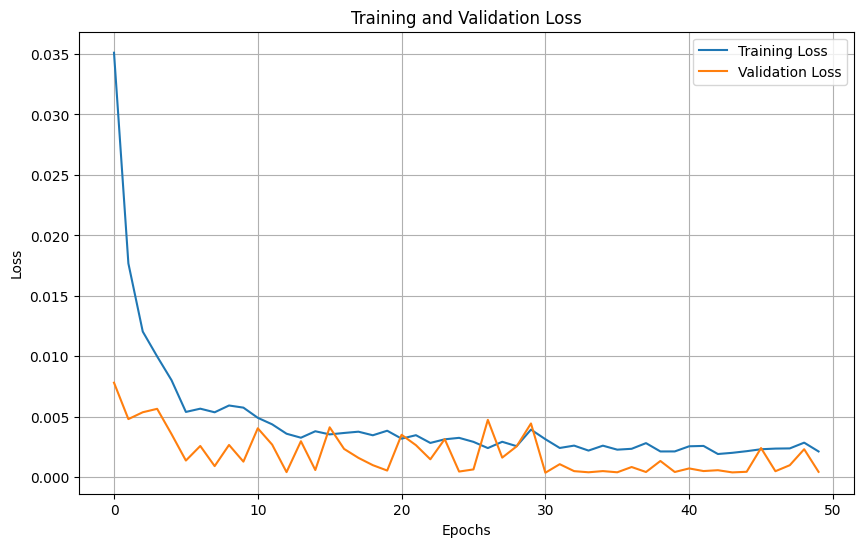

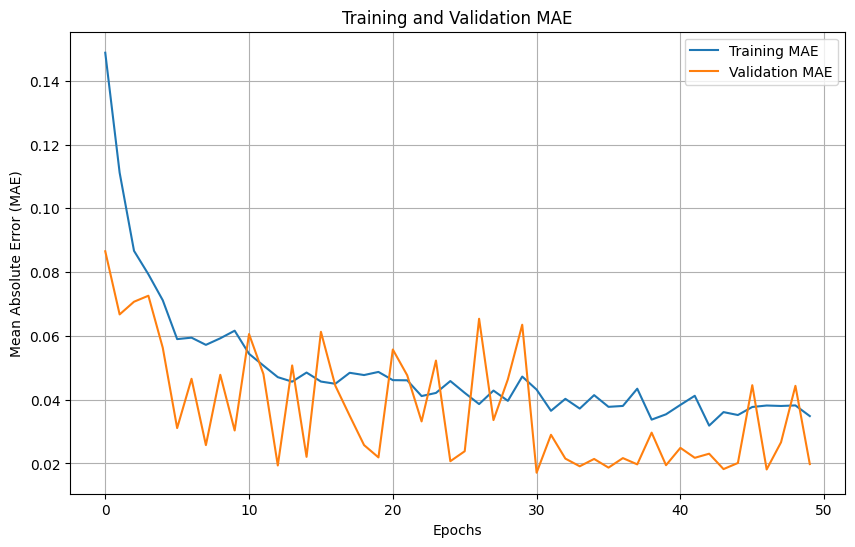

Training time: 0.3362352172533671 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0598 - mae: 0.2433
Test Loss: 0.05979083105921745
Test MAE: 0.24334293603897095


In [ ]:
train_attention_lstm(aapl_train, aapl_val, aapl_test, 'aapl_attention_lstm', model='None')

In [ ]:
aapl_model = tf.keras.models.load_model('/content/aapl_attention_lstm.keras')

(204, 21)
(204, 1)
(23, 21)
(23, 1)
(26, 21)
(26, 1)
X_train_seq shape: (184, 20, 21)
y_train_seq shape: (184, 1)
X_val_seq shape: (3, 20, 21)
y_val_seq shape: (3, 1)
X_test_seq shape: (6, 20, 21)
y_test_seq shape: (6, 1)
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0068 - mae: 0.0631 - val_loss: 0.0333 - val_mae: 0.1716
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069 - mae: 0.0653 - val_loss: 0.0378 - val_mae: 0.1841
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - mae: 0.0566 - val_loss: 0.0423 - val_mae: 0.1963
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0352 - val_mae: 0.1773
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026 - mae: 0.0385 - val_loss: 0.0427 - val_mae: 0.1974
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0032 - mae: 0.0421 - val_loss: 0.0434 - val_mae: 0.1991
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028 - mae: 0.0

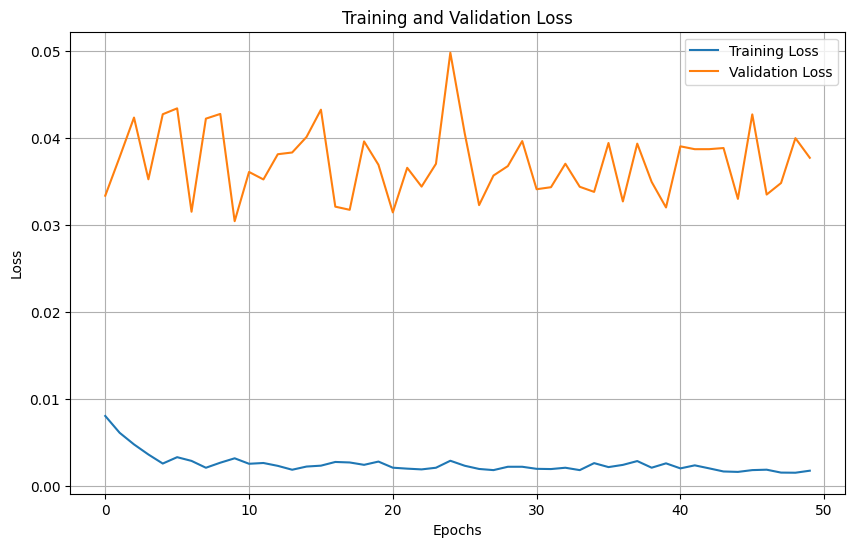

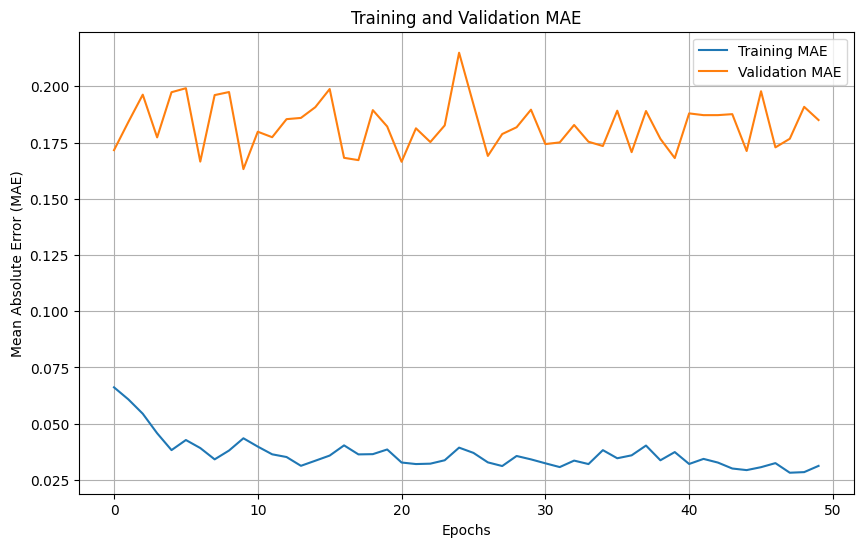

Training time: 0.3051267981529236 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3704 - mae: 0.6061
Test Loss: 0.37035778164863586
Test MAE: 0.6061227321624756


In [ ]:
train_attention_lstm(tsla_train, tsla_val, tsla_test, 'tsla_attention_lstm', model=aapl_model)

In [ ]:
tsla_model = tf.keras.models.load_model('/content/tsla_attention_lstm.keras')

(204, 21)
(204, 1)
(23, 21)
(23, 1)
(26, 21)
(26, 1)
X_train_seq shape: (184, 20, 21)
y_train_seq shape: (184, 1)
X_val_seq shape: (3, 20, 21)
y_val_seq shape: (3, 1)
X_test_seq shape: (6, 20, 21)
y_test_seq shape: (6, 1)
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0024 - mae: 0.0374 - val_loss: 0.0129 - val_mae: 0.1109
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025 - mae: 0.0402 - val_loss: 0.0152 - val_mae: 0.1203
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0373 - val_loss: 0.0181 - val_mae: 0.1321
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - mae: 0.0326 - val_loss: 0.0179 - val_mae: 0.1312
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 0.0265 - val_mae: 0.1612
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015 - mae: 0.0305 - val_loss: 0.0280 - val_mae: 0.1656
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - mae: 0.0

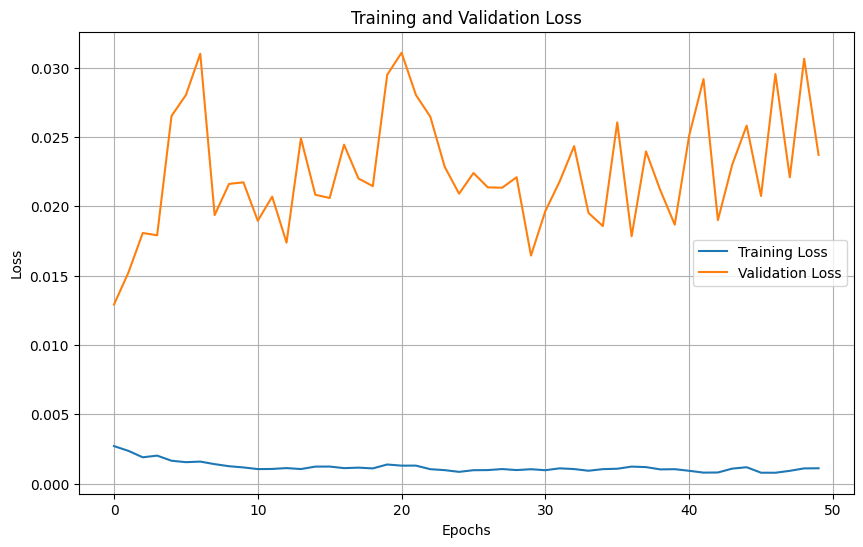

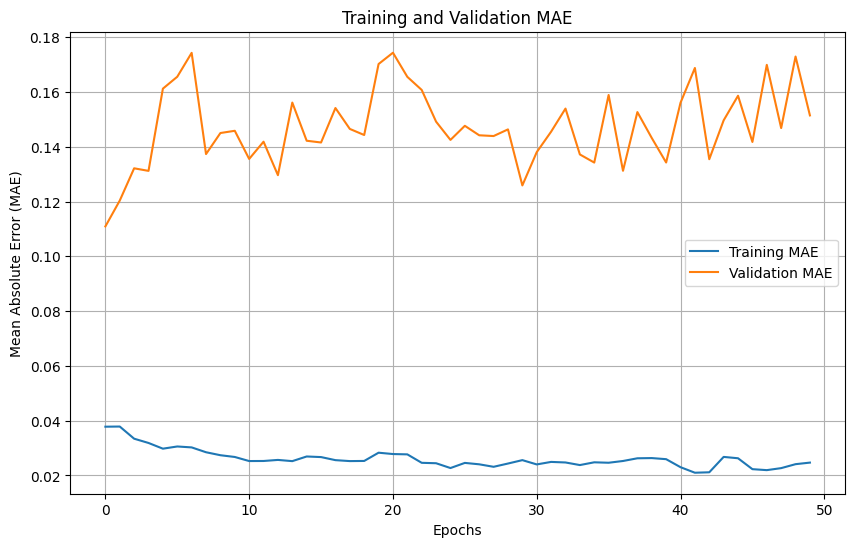

Training time: 0.3662983020146688 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.3297e-04 - mae: 0.0250
Test Loss: 0.0009329688618890941
Test MAE: 0.024962132796645164


In [ ]:
train_attention_lstm(ba_train, ba_val, ba_test, 'ba_attention_lstm', model=tsla_model)

### Evaluation of AAPL-TSLA-BA model

In [ ]:
aapl_model = tf.keras.models.load_model('/content/aapl_attention_lstm.keras')
tsla_model = tf.keras.models.load_model('/content/tsla_attention_lstm.keras')
ba_model = tf.keras.models.load_model('/content/ba_attention_lstm.keras')

In [ ]:
aapl_model.summary()

Model: "Attention_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 21)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 20, 128),      │         76,800 │ input_layer[0][0]      │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20, 1)          │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_Weights         │ (None, 20, 1)          │              0 │ dense[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Context_Vector (Multiply) │ (None, 20, 128)        │              0 │ Attention_Weights[0][… │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Summed_Context_Vector     │ (None, 128)            │              0 │ Context_Vector[0][0]   │
│ (SummedContextVector)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Combined_Vector           │ (None, 256)            │              0 │ Summed_Context_Vector… │
│ (Concatenate)             │                        │                │ lstm[0][1]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_1 (Dense)           │ (None, 64)             │         16,448 │ Combined_Vector[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dropout (Dropout)         │ (None, 64)             │              0 │ Dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 1)              │             65 │ Dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 280,328 (1.07 MB)

 Trainable params: 93,442 (365.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,886 (730.03 KB)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate_model(model, test_data, n_timesteps=20):
    # Reshape the test data
    X_test_seq, y_test_seq = df_to_X_y(test_data, n_timesteps)

    # Predict on the test set
    y_pred = model.predict(X_test_seq)

    # Evaluation scores
    r2 = r2_score(y_test_seq, y_pred)
    mse = mean_squared_error(y_test_seq, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_seq, y_pred)
    mape = np.mean(np.abs((y_test_seq - y_pred) / y_test_seq)) * 100

    print(f"R² - {model.name}: {r2}")
    print(f"MSE - {model.name}: {mse}")
    print(f"RMSE - {model.name}: {rmse}")
    print(f"MAE - {model.name}: {mae}")
    print(f"MAPE - {model.name}: {mape}")

    return r2, mse, rmse, mae, mape

In [ ]:
# Evaluate ba_model over aapl, tsla and ba test data
aapl_r2, aapl_mse, aapl_rmse, aapl_mae, aapl_mape = evaluate_model(ba_model, aapl_test)
tsla_r2, tsla_mse, tsla_rmse, tsla_mae, tsla_mape = evaluate_model(ba_model, tsla_test)
ba_r2, ba_mse, ba_rmse, ba_mae, ba_mape = evaluate_model(ba_model, ba_test)

(26, 21)
(26, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
R² - Attention_LSTM_Model: -39.56797192674725
MSE - Attention_LSTM_Model: 0.034683237275953745
RMSE - Attention_LSTM_Model: 0.1862343611580681
MAE - Attention_LSTM_Model: 0.15652978886835256
MAPE - Attention_LSTM_Model: 15.548862483694705
(26, 21)
(26, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
R² - Attention_LSTM_Model: -93.7445381560546
MSE - Attention_LSTM_Model: 0.3357223048007664
RMSE - Attention_LSTM_Model: 0.5794154854685595
MAE - Attention_LSTM_Model: 0.5756115629738826
MAPE - Attention_LSTM_Model: 39.78090651463932
(26, 21)
(26, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
R² - Attention_LSTM_Model: -1.2857202087454875
MSE - Attention_LSTM_Model: 0.0009329688997087387
RMSE - Attention_LSTM_Model: 0.0305445396054473
MAE - Attention_LSTM_Model: 0.024962137353424636
MAPE - Attention_LSTM_Model: 5.218813484168717


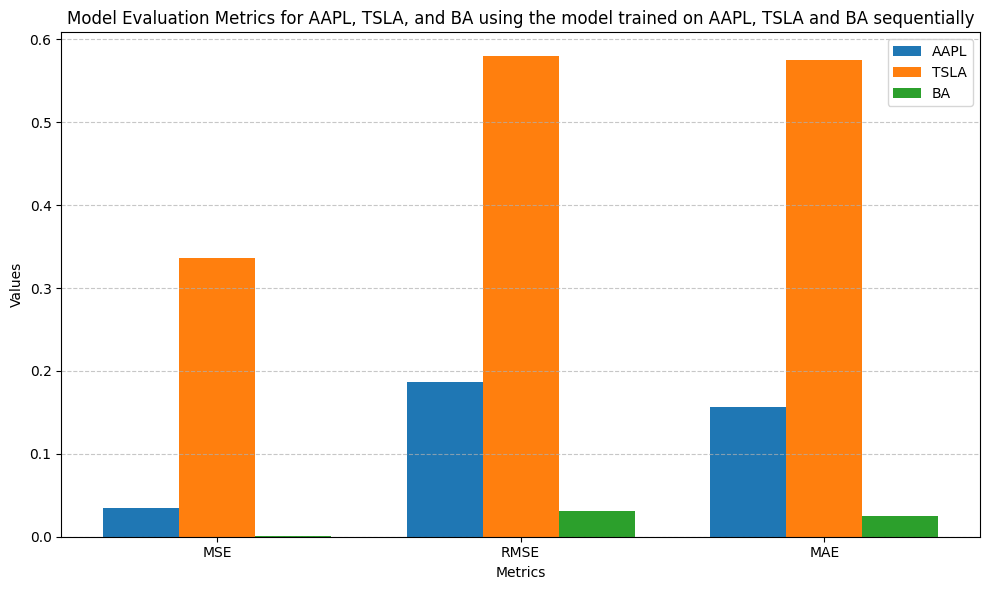

In [ ]:
# Metrics values
# aapl_metrics = [aapl_mse, aapl_rmse, aapl_mae, aapl_mape]
# tsla_metrics = [tsla_mse, tsla_rmse, tsla_mae, tsla_mape]
# ba_metrics = [ba_mse, ba_rmse, ba_mae, ba_mape]
aapl_metrics = [aapl_mse, aapl_rmse, aapl_mae]
tsla_metrics = [tsla_mse, tsla_rmse, tsla_mae]
ba_metrics = [ba_mse, ba_rmse, ba_mae]

# Metric labels
metrics_labels = ['MSE', 'RMSE', 'MAE']

# Bar width
bar_width = 0.25

# Bar positions
x = np.arange(len(metrics_labels))
x_aapl = x
x_tsla = x + bar_width
x_ba = x + 2 * bar_width

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_aapl, aapl_metrics, width=bar_width, label='AAPL')
plt.bar(x_tsla, tsla_metrics, width=bar_width, label='TSLA')
plt.bar(x_ba, ba_metrics, width=bar_width, label='BA')

# Add labels and titles
plt.xticks(x + bar_width, metrics_labels)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics for AAPL, TSLA, and BA using the model trained on AAPL, TSLA and BA sequentially')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

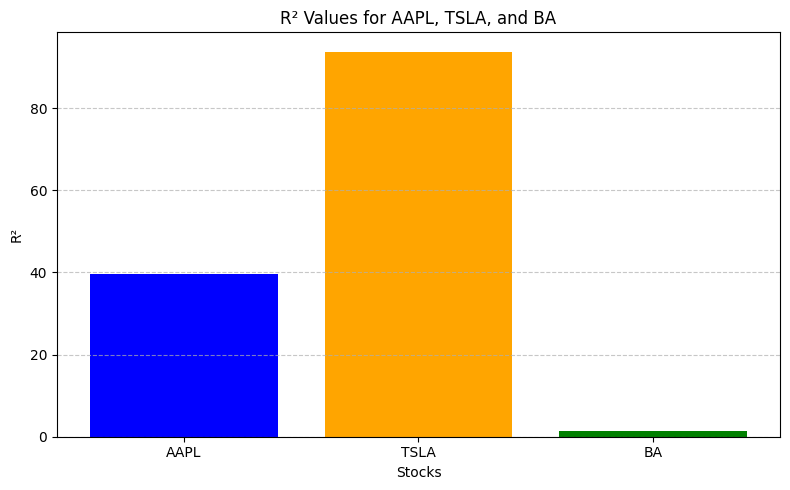

In [ ]:
import matplotlib.pyplot as plt

# Replace these placeholders with actual R² values
r2_values = [abs(aapl_r2), abs(tsla_r2), abs(ba_r2)]  # Example values for AAPL, TSLA, BA
stocks = ['AAPL', 'TSLA', 'BA']

# Create a bar plot for R² values
plt.figure(figsize=(8, 5))
plt.bar(stocks, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('Stocks')
plt.ylabel('R²')
plt.title('R² Values for AAPL, TSLA, and BA')
# plt.ylim(0, 1)  # R² typically ranges between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Training single models with and without sentiments

(204, 21)
(204, 1)
(23, 21)
(23, 1)
(26, 21)
(26, 1)
X_train_seq shape: (184, 20, 21)
y_train_seq shape: (184, 1)
X_val_seq shape: (3, 20, 21)
y_val_seq shape: (3, 1)
X_test_seq shape: (6, 20, 21)
y_test_seq shape: (6, 1)
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0428 - mae: 0.1629 - val_loss: 0.0076 - val_mae: 0.0849
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0118 - mae: 0.0914 - val_loss: 4.1407e-04 - val_mae: 0.0181
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0111 - mae: 0.0844 - val_loss: 0.0016 - val_mae: 0.0336
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0071 - mae: 0.0697 - val_loss: 0.0024 - val_mae: 0.0439
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0066 - mae: 0.0627 - val_loss: 0.0020 - val_mae: 0.0392
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066 - mae: 0.0662 - val_loss: 0.0015 - val_mae: 0.0325
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0063 - mae:

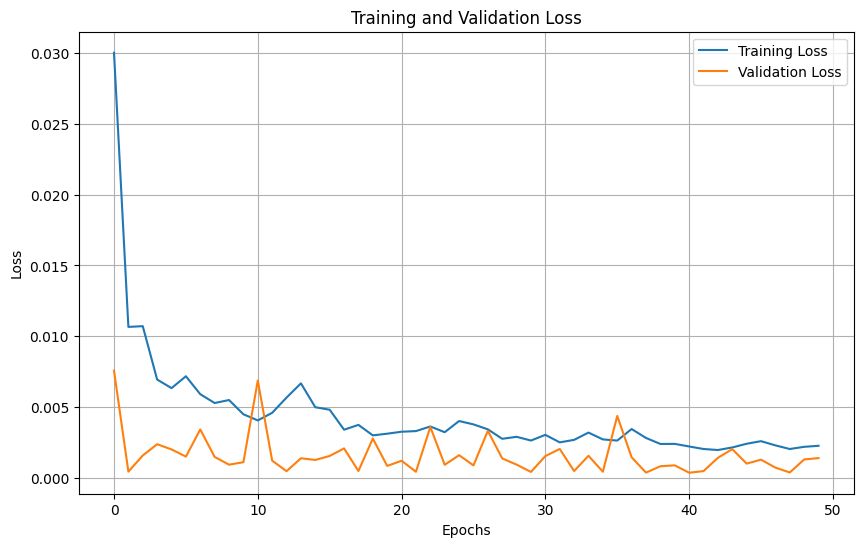

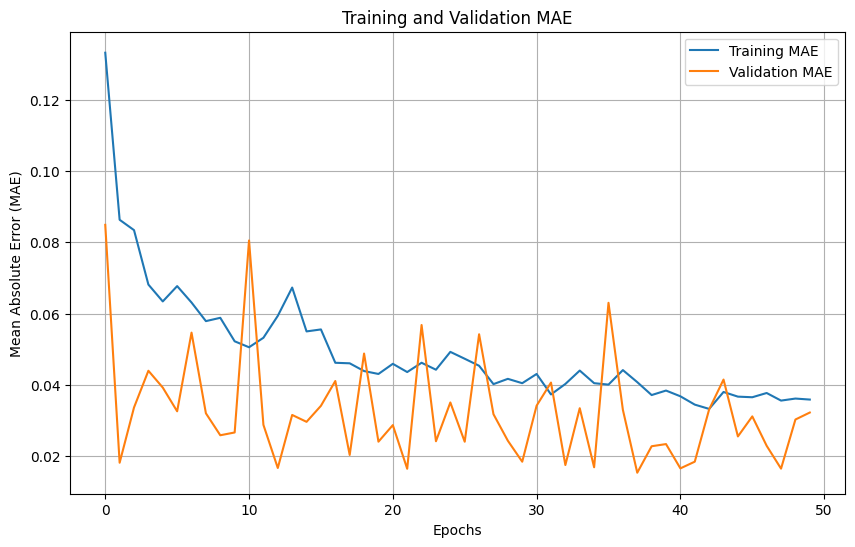

Training time: 0.3107467730840047 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0339 - mae: 0.1821
Test Loss: 0.03389427438378334
Test MAE: 0.18211804330348969


In [ ]:
train_attention_lstm(aapl_train, aapl_val, aapl_test, 'aapl_attention_lstm_single', model='None')

### No sentiment apple training

In [ ]:
# Remove the sentiment analysis columns
def remove_sentiment_analysis_columns(array):
    new_array = array[:, :-6]
    print(new_array.shape)
    return new_array

aapl_no_sentiment_train = remove_sentiment_analysis_columns(aapl_train)
aapl_no_sentiment_val = remove_sentiment_analysis_columns(aapl_val)
aapl_no_sentiment_test = remove_sentiment_analysis_columns(aapl_test)



(204, 16)
(23, 16)
(26, 16)


(204, 15)
(204, 1)
(23, 15)
(23, 1)
(26, 15)
(26, 1)
X_train_seq shape: (184, 20, 15)
y_train_seq shape: (184, 1)
X_val_seq shape: (3, 20, 15)
y_val_seq shape: (3, 1)
X_test_seq shape: (6, 20, 15)
y_test_seq shape: (6, 1)
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0367 - mae: 0.1502 - val_loss: 0.0185 - val_mae: 0.1341
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0347 - mae: 0.1488 - val_loss: 0.0519 - val_mae: 0.2269
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0340 - mae: 0.1481 - val_loss: 0.0185 - val_mae: 0.1346
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0251 - mae: 0.1167 - val_loss: 0.0092 - val_mae: 0.0936
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0295 - mae: 0.1300 - val_loss: 0.0143 - val_mae: 0.1181
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0282 - mae: 0.1266 - val_loss: 0.0235 - val_mae: 0.1520
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0188 - mae: 0.1

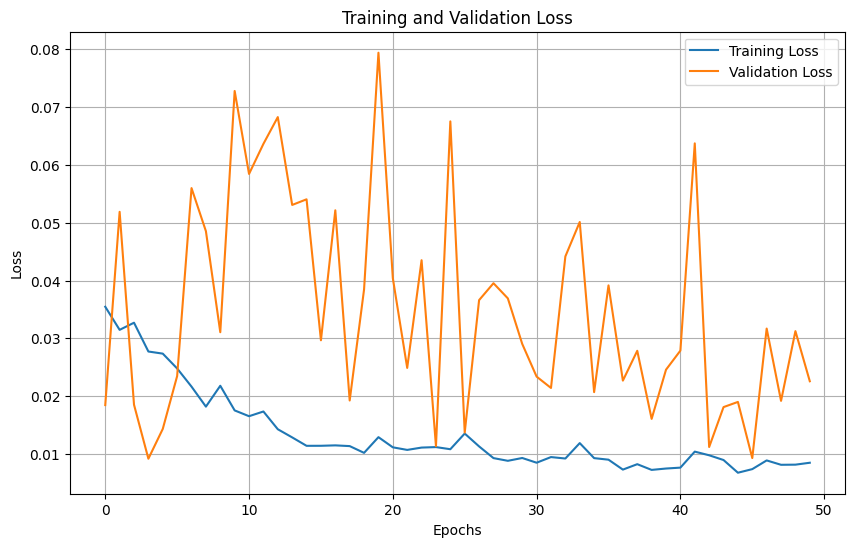

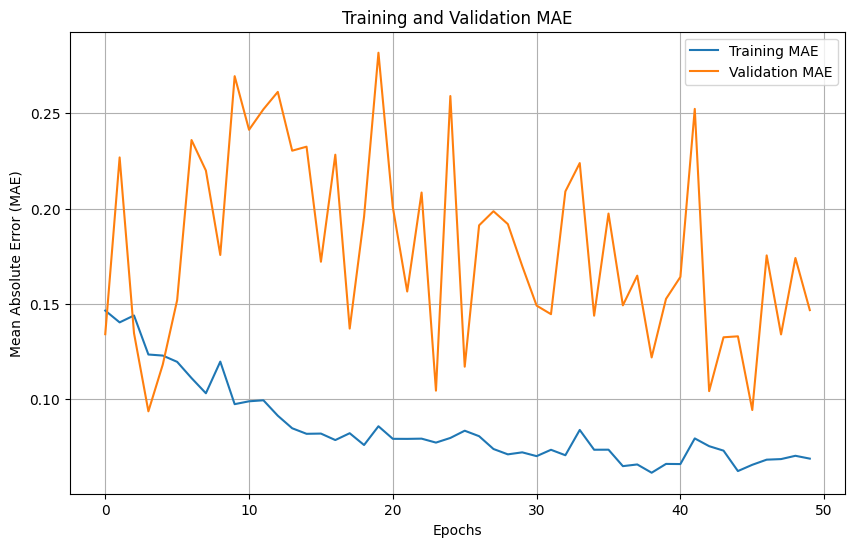

Training time: 0.35262425740559894 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0129 - mae: 0.0932
Test Loss: 0.012941411696374416
Test MAE: 0.09319674223661423


In [ ]:
train_attention_lstm(aapl_no_sentiment_train, aapl_no_sentiment_val, aapl_no_sentiment_test, 'aapl_attention_lstm_single_no_sentiment', model='None')

# Concatenate datasets

(612, 21)
(612, 1)
(69, 21)
(69, 1)
(78, 21)
(78, 1)
X_train_seq shape: (592, 20, 21)
y_train_seq shape: (592, 1)
X_val_seq shape: (49, 20, 21)
y_val_seq shape: (49, 1)
X_test_seq shape: (58, 20, 21)
y_test_seq shape: (58, 1)
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0576 - mae: 0.1831 - val_loss: 0.0585 - val_mae: 0.2129
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0251 - mae: 0.1104 - val_loss: 0.0531 - val_mae: 0.1936
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0235 - mae: 0.1126 - val_loss: 0.0422 - val_mae: 0.1544
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0137 - mae: 0.0821 - val_loss: 0.0371 - val_mae: 0.1444
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0084 - mae: 0.0672 - val_loss: 0.0333 - val_mae: 0.1260
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0072 - mae: 0.0577 - val_loss: 0.0365 - val_mae: 0.1295
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0082 - mae:

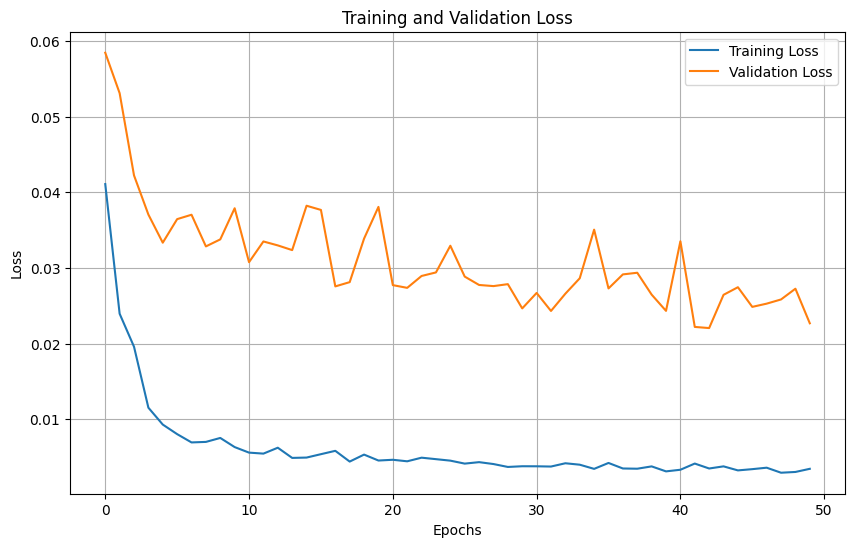

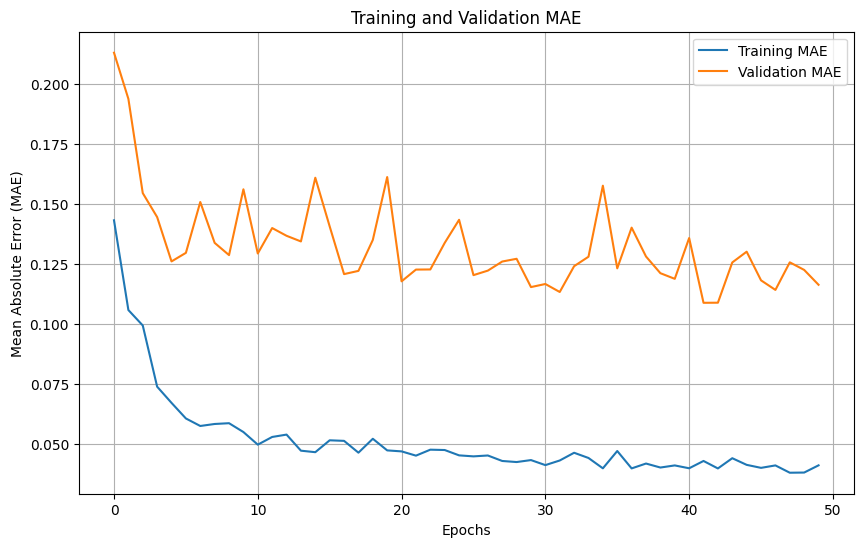

Training time: 0.7069471756617228 minutes
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0888 - mae: 0.2477
Test Loss: 0.07503960281610489
Test MAE: 0.2158263921737671


In [ ]:
train_attention_lstm(concatenate_dataset_train, concatenate_dataset_val, concatenate_dataset_test, 'concatenate_attention_lstm', model='None')

In [ ]:
concatenate_model = tf.keras.models.load_model('/content/concatenate_attention_lstm.keras')

concat_r2, concat_mse, concat_rmse, concat_mae, concat_mape = evaluate_model(concatenate_model, concatenate_dataset_test)

(78, 21)
(78, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
R² - Attention_LSTM_Model: 0.5099722488914675
MSE - Attention_LSTM_Model: 0.07503960288216066
RMSE - Attention_LSTM_Model: 0.2739335738498672
MAE - Attention_LSTM_Model: 0.21582639236380924
MAPE - Attention_LSTM_Model: 21.87446765705865


(612, 16)
(69, 16)
(78, 16)
(612, 15)
(612, 1)
(69, 15)
(69, 1)
(78, 15)
(78, 1)
X_train_seq shape: (592, 20, 15)
y_train_seq shape: (592, 1)
X_val_seq shape: (49, 20, 15)
y_val_seq shape: (49, 1)
X_test_seq shape: (58, 20, 15)
y_test_seq shape: (58, 1)
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0434 - mae: 0.1626 - val_loss: 0.0383 - val_mae: 0.1724
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0342 - mae: 0.1425 - val_loss: 0.0333 - val_mae: 0.1615
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0270 - mae: 0.1278 - val_loss: 0.0305 - val_mae: 0.1524
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0243 - mae: 0.1171 - val_loss: 0.0288 - val_mae: 0.1446
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0188 - mae: 0.1054 - val_loss: 0.0357 - val_mae: 0.1584
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0166 - mae: 0.0985 - val_loss: 0.0258 - val_mae: 0.1346
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18m

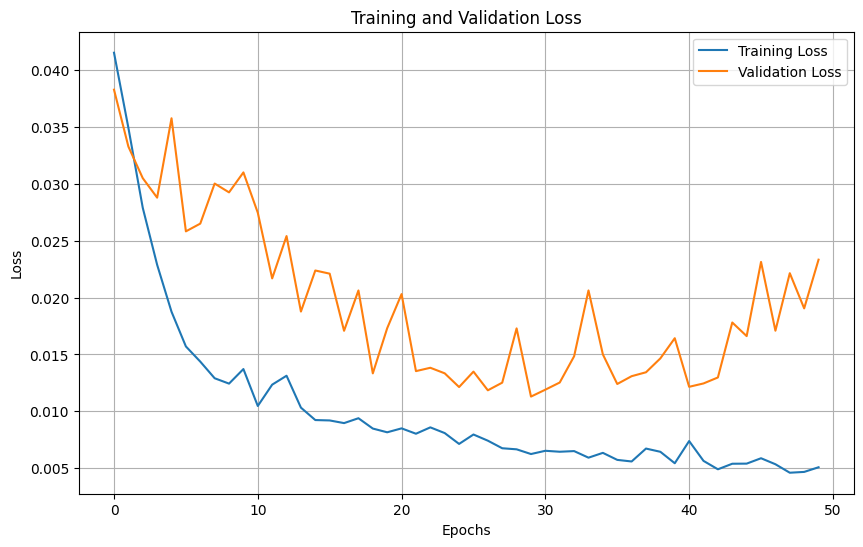

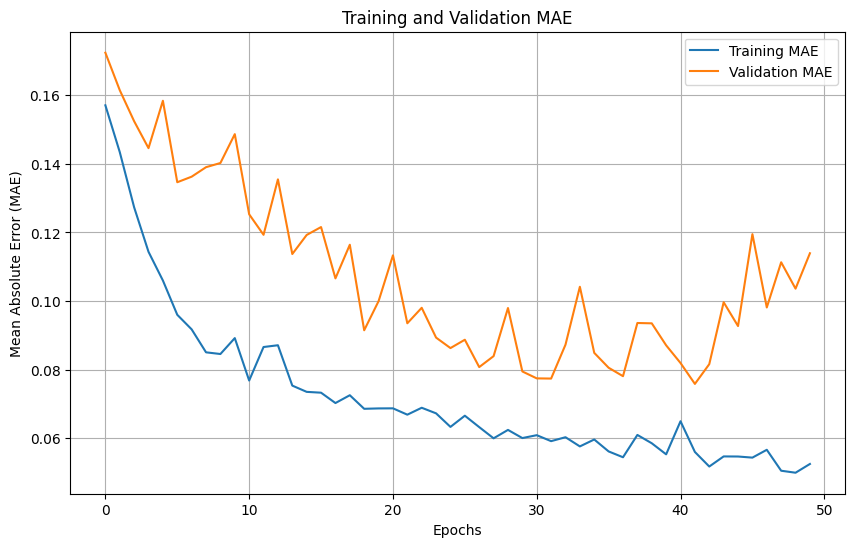

Training time: 1.125572180747986 minutes
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0410 - mae: 0.1466
Test Loss: 0.03459140658378601
Test MAE: 0.1296386569738388


In [ ]:
# Remove the sentiment analysis columns
def remove_sentiment_analysis_columns(array):
    new_array = array[:, :-6]
    print(new_array.shape)
    return new_array

concatenate_no_sentiment_train = remove_sentiment_analysis_columns(concatenate_dataset_train)
concatenate_no_sentiment_val = remove_sentiment_analysis_columns(concatenate_dataset_val)
concatenate_no_sentiment_test = remove_sentiment_analysis_columns(concatenate_dataset_test)

train_attention_lstm(concatenate_no_sentiment_train, concatenate_no_sentiment_val, concatenate_no_sentiment_test, 'concatenate_no_emotionn_attention_lstm', model='None')

In [ ]:
concatenate_no_emotion_model = tf.keras.models.load_model('/content/concatenate_no_emotionn_attention_lstm.keras')

concat_NE_r2, concat_NE_mse, concat_NE_rmse, concat_NE_mae, concat_NE_mape = evaluate_model(concatenate_no_emotion_model, concatenate_no_sentiment_test)

(78, 15)
(78, 1)
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 782ms/step
R² - Attention_LSTM_Model: -0.03744457255901157
MSE - Attention_LSTM_Model: 0.03459140797887059
RMSE - Attention_LSTM_Model: 0.18598765544753393
MAE - Attention_LSTM_Model: 0.12963866866747578
MAPE - Attention_LSTM_Model: 16.501938430146364


# V2


In [ ]:
import tensorflow as tf
from keras.api.models import Model
from keras.api.layers import (
    Input,
    LSTM,
    Layer,
    Dense,
    Dropout,
    Activation,
    Attention,
    TimeDistributed,
    Concatenate,
    RepeatVector,
    Multiply,
    Lambda
)
from keras.api.saving import register_keras_serializable


@register_keras_serializable()
class SummedContextVector(Layer):
    def __init__(self, **kwargs):
        super(SummedContextVector, self).__init__(**kwargs)

    def call(self, inputs):
        # Sum over the time axis (axis=1)
        return tf.reduce_sum(inputs, axis=1)

# Define the LSTM model with Attention
def create_lstm_attention_model_V2(input_shape, num_lstm_units, dropout_rate):
    """
    Builds an LSTM model with an attention mechanism.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    Model: A compiled Keras model with attention.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out, state_h, forward_c = LSTM(units=num_lstm_units,
                                          return_sequences=True,
                                          return_state=True)(inputs)


    # Attention Layer
    attention = Dense(1, activation="tanh")(lstm_out)
    attention_weights = Activation("sigmoid", name="Attention_Weights")(attention)
    context_vector = Multiply(name="Context_Vector")([attention_weights, lstm_out])

    # Sum over the time axis using the custom layer
    context_vector = SummedContextVector(name="Summed_Context_Vector")(context_vector)

    # Sum over the time axis using a Lambda layer
    # context_vector = Lambda(
    #     lambda x: tf.reduce_sum(x, axis=1), name="Summed_Context_Vector"
    # )(context_vector)
    # Combine Context and LSTM Final State
    combined_vector = Concatenate(name="Combined_Vector")(
        [context_vector, state_h]
    )

    # Combine Context and LSTM Final State
    combined_vector = Concatenate(name="Combined_Vector")(
        [context_vector, state_h]
    )

    # Fully Connected Layers
    dense1 = Dense(64, activation="sigmoid", name="Dense_1")(combined_vector)
    dropout = Dropout(dropout_rate, name="Dropout")(dense1)
    outputs = Dense(1, activation="sigmoid", name="Output_Layer")(dropout)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs, name="Attention_LSTM_Model")

    return model


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to reshape the data for LSTM
def df_to_X_y(df, look_back_days=20):
    # df_to_np = df.to_numpy()
    # print(df_to_np.shape)

    X, y = [], []

    temp_X = df[:, :-1]
    print(temp_X.shape)

    temp_y = df[:, -1:]
    print(temp_y.shape)

    for i in range(len(temp_X)-look_back_days):
        row = [a for a in temp_X[i:i+look_back_days]]
        X.append(row)

    y = temp_y[look_back_days:]

        # label = temp_y[i+look_back_days]
        # y.append(label)

    return np.array(X), np.array(y)



In [ ]:
# concatenate training sequential data
aapl_X_train, aapl_y_train = df_to_X_y(aapl_train)
tsla_X_train, tsla_y_train = df_to_X_y(tsla_train)
ba_X_train, ba_y_train = df_to_X_y(ba_train)
X_train = np.concatenate((aapl_X_train, tsla_X_train, ba_X_train), axis=0)
y_train = np.concatenate((aapl_y_train, tsla_y_train, ba_y_train), axis=0)
print(f"X train : {X_train.shape}")
print(f"y train : {y_train.shape}")

# concatenate validation sequential data
aapl_X_val, aapl_y_val = df_to_X_y(aapl_val)
tsla_X_val, tsla_y_val = df_to_X_y(tsla_val)
ba_X_val, ba_y_val = df_to_X_y(ba_val)
X_val = np.concatenate((aapl_X_val, tsla_X_val, ba_X_val), axis=0)
y_val = np.concatenate((aapl_y_val, tsla_y_val, ba_y_val), axis=0)
print(f"X val : {X_val.shape}")
print(f"y val : {y_val.shape}")

# concatenate test sequential data
aapl_X_test, aapl_y_test = df_to_X_y(aapl_test)
tsla_X_test, tsla_y_test = df_to_X_y(tsla_test)
ba_X_test, ba_y_test = df_to_X_y(ba_test)
X_test = np.concatenate((aapl_X_test, tsla_X_test, ba_X_test), axis=0)
y_test = np.concatenate((aapl_y_test, tsla_y_test, ba_y_test), axis=0)
print(f"X test : {X_test.shape}")
print(f"y test : {y_test.shape}")

(204, 21)
(204, 1)
(204, 21)
(204, 1)
(204, 21)
(204, 1)
X train : (552, 20, 21)
y train : (552, 1)
(23, 21)
(23, 1)
(23, 21)
(23, 1)
(23, 21)
(23, 1)
X val : (9, 20, 21)
y val : (9, 1)
(26, 21)
(26, 1)
(26, 21)
(26, 1)
(26, 21)
(26, 1)
X test : (18, 20, 21)
y test : (18, 1)


In [ ]:
def train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               model_name,
               lstm_units,
               model_to_use=None):

    # Print new shapes
    print("X_train_seq shape:", X_train.shape)  # (samples, timesteps, features)
    print("y_train_seq shape:", y_train.shape)
    print("X_val_seq shape:", X_val.shape)
    print("y_val_seq shape:", y_val.shape)
    print("X_test_seq shape:", X_test.shape)
    print("y_test_seq shape:", y_test.shape)

    # Build the LSTM Model
    if model_to_use == None:
        print("Creating new model...")
        model_to_use = create_lstm_attention_model_V2(input_shape=(X_train.shape[1], X_train.shape[2]), num_lstm_units=lstm_units, dropout_rate=0.2)
        # print(model_to_use.summary())
    else:
        print("Using the loaded model")
        model_to_use = model_to_use

    # Compile the model
    model_to_use.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    start_time = time.time()
    history = model_to_use.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=30,
        verbose=1
    )
    end_time = time.time()

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the training and validation MAE
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the training time
    print(f"Training time: {(end_time - start_time)/60} minutes")

    # Evaluate on the test set
    test_loss, test_mae = model_to_use.evaluate(X_test, y_test, verbose=1)
    print("Test Loss:", test_loss)
    print("Test MAE:", test_mae)


    # Save the model
    model_to_use.save(f'{model_name}.keras')


X_train_seq shape: (552, 20, 21)
y_train_seq shape: (552, 1)
X_val_seq shape: (9, 20, 21)
y_val_seq shape: (9, 1)
X_test_seq shape: (18, 20, 21)
y_test_seq shape: (18, 1)
Creating new model...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1189 - mae: 0.2791 - val_loss: 0.0231 - val_mae: 0.1170
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0366 - mae: 0.1374 - val_loss: 0.0330 - val_mae: 0.1519
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0234 - mae: 0.1087 - val_loss: 0.0390 - val_mae: 0.1648
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0179 - mae: 0.0965 - val_loss: 0.0249 - val_mae: 0.1313
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0135 - mae: 0.0842 - val_loss: 0.0264 - val_mae: 0.1329
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0109 - mae: 0.0780 - val_loss: 0.0252 - val_mae: 0.1340
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0089 - mae: 0.0727 - val_loss: 0.0176 - val_

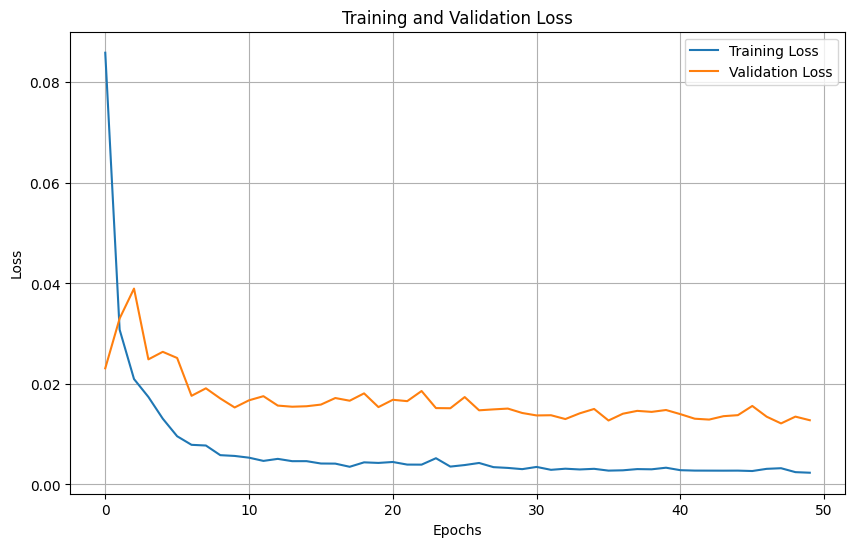

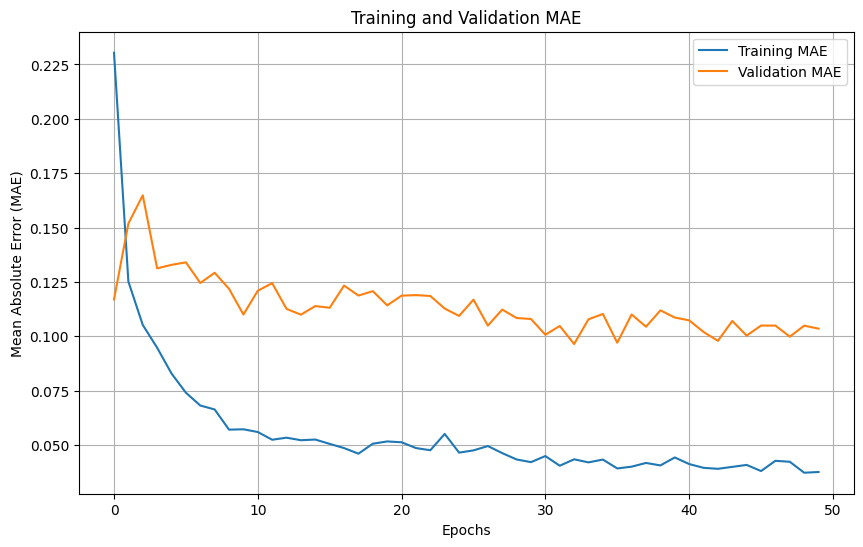

Training time: 0.6778552969296773 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0898 - mae: 0.2000
Test Loss: 0.08982110023498535
Test MAE: 0.199983149766922


In [ ]:
train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               "concat_seq_data_att_lstm",
                lstm_units=128)

X_train_seq shape: (552, 20, 21)
y_train_seq shape: (552, 1)
X_val_seq shape: (9, 20, 21)
y_val_seq shape: (9, 1)
X_test_seq shape: (18, 20, 21)
y_test_seq shape: (18, 1)
Creating new model...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0502 - mae: 0.1661 - val_loss: 0.0311 - val_mae: 0.1409
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0193 - mae: 0.0989 - val_loss: 0.0212 - val_mae: 0.1230
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0153 - mae: 0.0879 - val_loss: 0.0271 - val_mae: 0.1440
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0066 - mae: 0.0613 - val_loss: 0.0216 - val_mae: 0.1413
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0061 - mae: 0.0590 - val_loss: 0.0160 - val_mae: 0.1132
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0107 - mae: 0.0778 - val_loss: 0.0178 - val_mae: 0.1244
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0065 - mae: 0.0582 - val_loss: 0.0174 - val

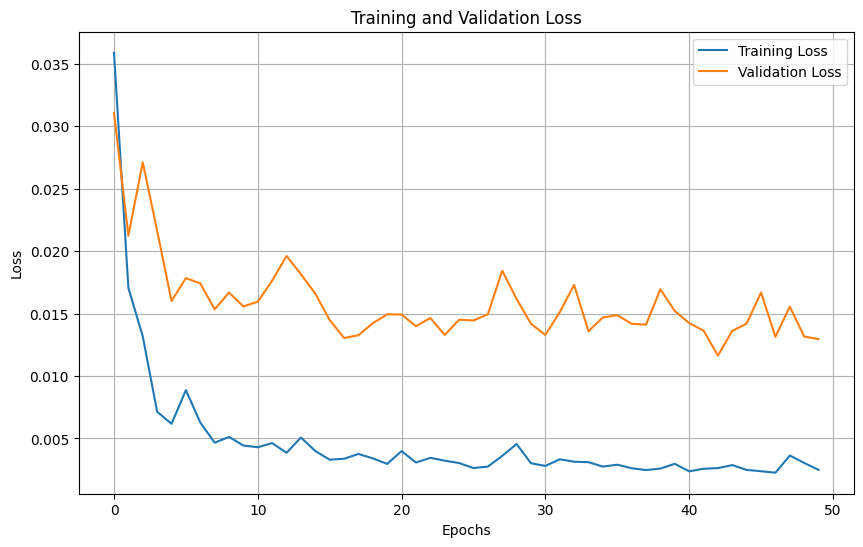

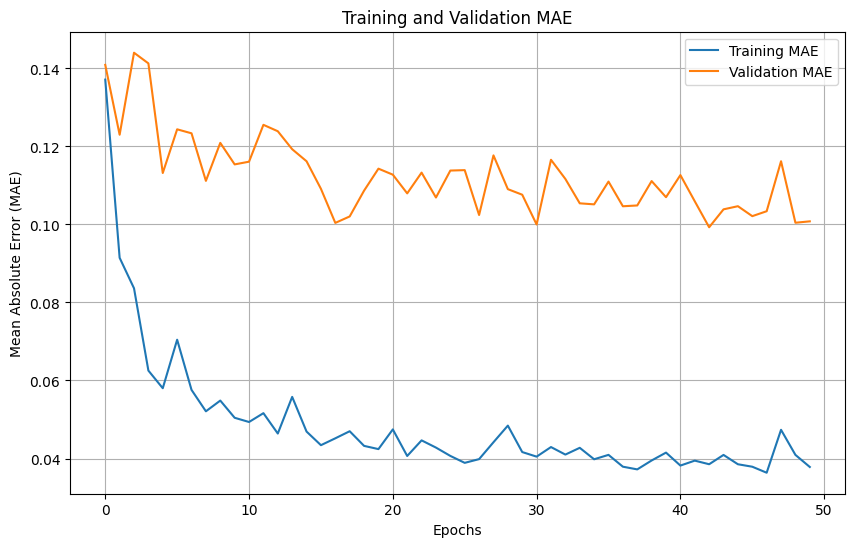

Training time: 1.1591503461201986 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0939 - mae: 0.2132
Test Loss: 0.09389039129018784
Test MAE: 0.2131740152835846


In [ ]:
train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               "concat_seq_data_att_lstm_256",
                lstm_units=256)

X_train_seq shape: (552, 20, 21)
y_train_seq shape: (552, 1)
X_val_seq shape: (9, 20, 21)
y_val_seq shape: (9, 1)
X_test_seq shape: (18, 20, 21)
y_test_seq shape: (18, 1)
Creating new model...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - loss: 0.0734 - mae: 0.2125 - val_loss: 0.0494 - val_mae: 0.1984
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - loss: 0.0252 - mae: 0.1180 - val_loss: 0.0206 - val_mae: 0.1356
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - loss: 0.0194 - mae: 0.0896 - val_loss: 0.0182 - val_mae: 0.1187
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0137 - mae: 0.0822 - val_loss: 0.0263 - val_mae: 0.1438
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0080 - mae: 0.0690 - val_loss: 0.0177 - val_mae: 0.1214
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - loss: 0.0078 - mae: 0.0662 - val_loss: 0.0163 - val_mae: 0.1146
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0096 - mae: 0.0688 - val_loss: 0.0259

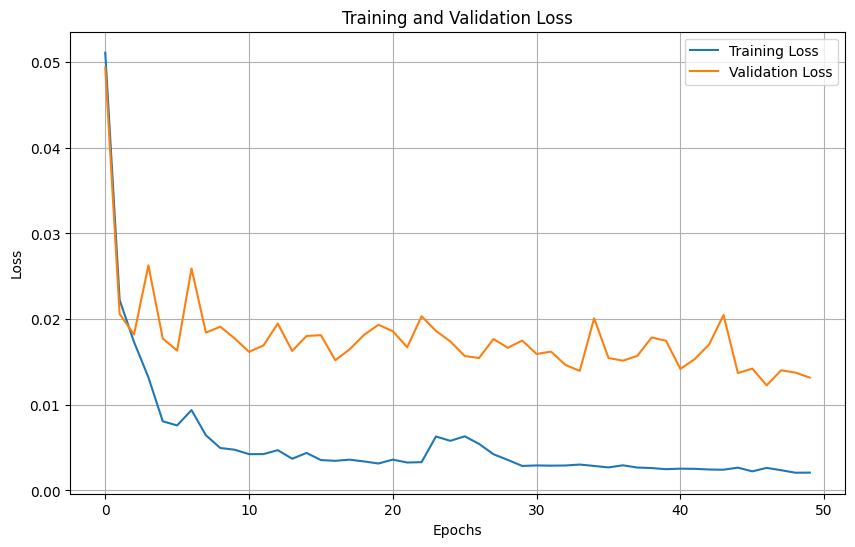

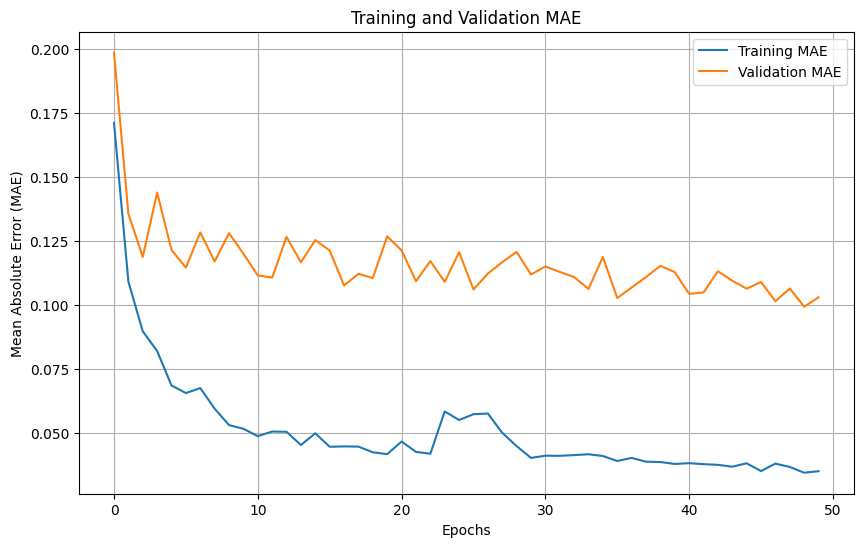

Training time: 3.8285693605740865 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1004 - mae: 0.2221
Test Loss: 0.10037025809288025
Test MAE: 0.22206808626651764


In [ ]:
train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               "concat_seq_data_att_lstm_512",
                lstm_units=512)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate_model_V2(model, X_test, y_test):

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluation scores
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"R² - {model.name}: {r2}")
    print(f"MSE - {model.name}: {mse}")
    print(f"RMSE - {model.name}: {rmse}")
    print(f"MAE - {model.name}: {mae}")
    print(f"MAPE - {model.name}: {mape}")

    return r2, mse, rmse, mae, mape

In [ ]:
# load models

model_128 = tf.keras.models.load_model('/content/concat_seq_data_att_lstm.keras')
model_256 = tf.keras.models.load_model('/content/concat_seq_data_att_lstm_256.keras')
model_512 = tf.keras.models.load_model('/content/concat_seq_data_att_lstm_512.keras')


# Evaluate them
print("Model 128")
evaluate_model_V2(model_128, X_test, y_test)
print("Model 256")
evaluate_model_V2(model_256, X_test, y_test)
print("Model 512")
evaluate_model_V2(model_512, X_test, y_test)

Model 128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
R² - Attention_LSTM_Model: 0.43172927939837225
MSE - Attention_LSTM_Model: 0.08982109844572578
RMSE - Attention_LSTM_Model: 0.2997016824205793
MAE - Attention_LSTM_Model: 0.1999831507846611
MAPE - Attention_LSTM_Model: 15.241850532567069
Model 256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
R² - Attention_LSTM_Model: 0.4059841354316335
MSE - Attention_LSTM_Model: 0.09389038624624386
RMSE - Attention_LSTM_Model: 0.30641538186952016
MAE - Attention_LSTM_Model: 0.21317400673534795
MAPE - Attention_LSTM_Model: 16.946181387237388
Model 512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
R² - Attention_LSTM_Model: 0.364987939945593
MSE - Attention_LSTM_Model: 0.10037026137821159
RMSE - Attention_LSTM_Model: 0.31681265975054024
MAE - Attention_LSTM_Model: 0.22206809593081134
MAPE - Attention_LSTM_Model: 17.721940576166112


(0.364987939945593,
 0.10037026137821159,
 0.31681265975054024,
 0.22206809593081134,
 17.721940576166112)

# V2 No emotion

In [ ]:
# Remove the sentiment analysis columns
def remove_sentiment_analysis_columns(array):
    new_array = array[:, :-6]
    print(new_array.shape)
    return new_array



In [ ]:
# concatenate training sequential data
aapl_NE_X_train, aapl_NE_y_train = df_to_X_y(aapl_train[:,:-6])
tsla_NE_X_train, tsla_NE_y_train = df_to_X_y(tsla_train[:,:-6])
ba_NE_X_train, ba_NE_y_train = df_to_X_y(ba_train[:,:-6])
X_NE_train = np.concatenate((aapl_NE_X_train, tsla_NE_X_train, ba_NE_X_train), axis=0)
y_NE_train = np.concatenate((aapl_NE_y_train, tsla_NE_y_train, ba_NE_y_train), axis=0)
print(f"X train : {X_NE_train.shape}")
print(f"y train : {y_NE_train.shape}")

# concatenate validation sequential data
aapl_NE_X_val, aapl_NE_y_val = df_to_X_y(aapl_val[:,:-6])
tsla_NE_X_val, tsla_NE_y_val = df_to_X_y(tsla_val[:,:-6])
ba_NE_X_val, ba_NE_y_val = df_to_X_y(ba_val[:,:-6])
X_NE_val = np.concatenate((aapl_NE_X_val, tsla_NE_X_val, ba_NE_X_val), axis=0)
y_NE_val = np.concatenate((aapl_NE_y_val, tsla_NE_y_val, ba_NE_y_val), axis=0)
print(f"X val : {X_NE_val.shape}")
print(f"y val : {y_NE_val.shape}")

# concatenate test sequential data
aapl_NE_X_test, aapl_NE_y_test = df_to_X_y(aapl_test[:,:-6])
tsla_NE_X_test, tsla_NE_y_test = df_to_X_y(tsla_test[:,:-6])
ba_NE_X_test, ba_NE_y_test = df_to_X_y(ba_test[:,:-6])
X_NE_test = np.concatenate((aapl_NE_X_test, tsla_NE_X_test, ba_NE_X_test), axis=0)
y_NE_test = np.concatenate((aapl_NE_y_test, tsla_NE_y_test, ba_NE_y_test), axis=0)
print(f"X test : {X_NE_test.shape}")
print(f"y test : {y_NE_test.shape}")


(204, 15)
(204, 1)
(204, 15)
(204, 1)
(204, 15)
(204, 1)
X train : (552, 20, 15)
y train : (552, 1)
(23, 15)
(23, 1)
(23, 15)
(23, 1)
(23, 15)
(23, 1)
X val : (9, 20, 15)
y val : (9, 1)
(26, 15)
(26, 1)
(26, 15)
(26, 1)
(26, 15)
(26, 1)
X test : (18, 20, 15)
y test : (18, 1)


X_train_seq shape: (552, 20, 21)
y_train_seq shape: (552, 1)
X_val_seq shape: (9, 20, 21)
y_val_seq shape: (9, 1)
X_test_seq shape: (18, 20, 21)
y_test_seq shape: (18, 1)
Creating new model...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0684 - mae: 0.2097 - val_loss: 0.0152 - val_mae: 0.1077
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0236 - mae: 0.1059 - val_loss: 0.0390 - val_mae: 0.1680
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0143 - mae: 0.0859 - val_loss: 0.0300 - val_mae: 0.1429
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0136 - mae: 0.0824 - val_loss: 0.0202 - val_mae: 0.1292
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0092 - mae: 0.0687 - val_loss: 0.0280 - val_mae: 0.1464
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0081 - mae: 0.0687 - val_loss: 0.0218 - val_mae: 0.1379
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0056 - mae: 0.0592 - val_loss: 0.0162 - val_

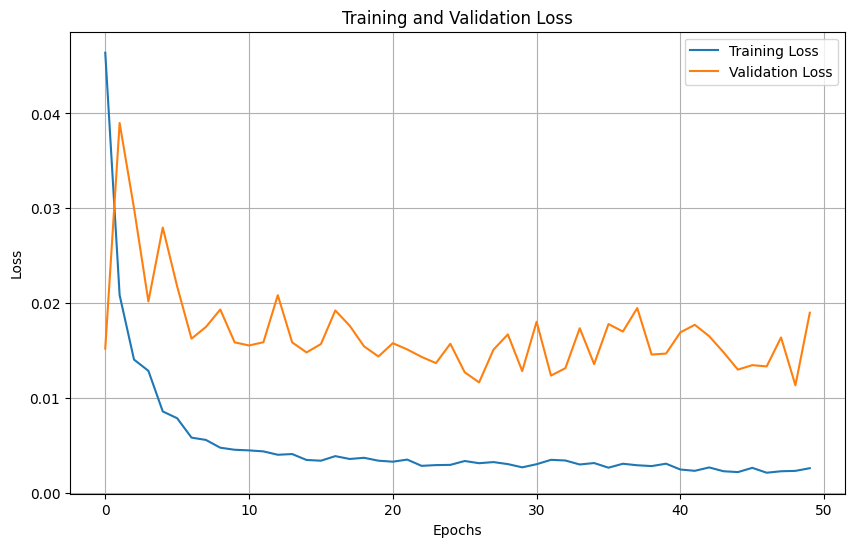

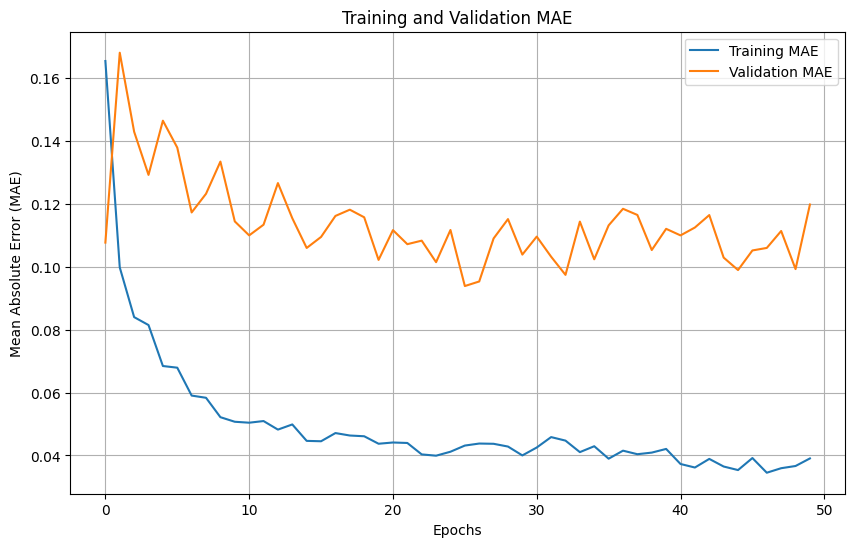

Training time: 0.6110487977663676 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1147 - mae: 0.2538
Test Loss: 0.11469544470310211
Test MAE: 0.25381219387054443


In [ ]:
train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               "concat_seq_data_att_lstm_128_NE",
                lstm_units=128)

X_train_seq shape: (552, 20, 21)
y_train_seq shape: (552, 1)
X_val_seq shape: (9, 20, 21)
y_val_seq shape: (9, 1)
X_test_seq shape: (18, 20, 21)
y_test_seq shape: (18, 1)
Creating new model...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0569 - mae: 0.1829 - val_loss: 0.0354 - val_mae: 0.1559
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0173 - mae: 0.0940 - val_loss: 0.0301 - val_mae: 0.1494
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0140 - mae: 0.0872 - val_loss: 0.0214 - val_mae: 0.1350
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0084 - mae: 0.0654 - val_loss: 0.0227 - val_mae: 0.1437
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0077 - mae: 0.0644 - val_loss: 0.0311 - val_mae: 0.1427
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0085 - mae: 0.0697 - val_loss: 0.0290 - val_mae: 0.1374
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0067 - mae: 0.0605 - val_loss: 0.0196 - val_

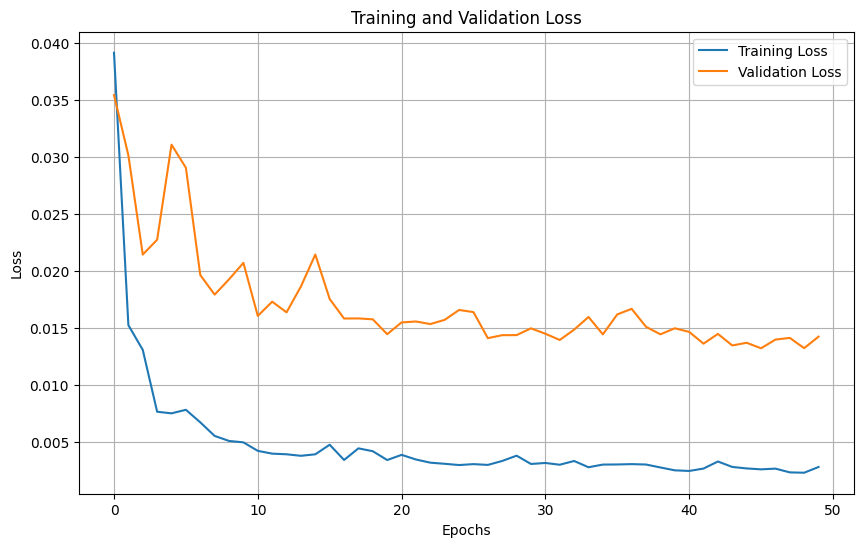

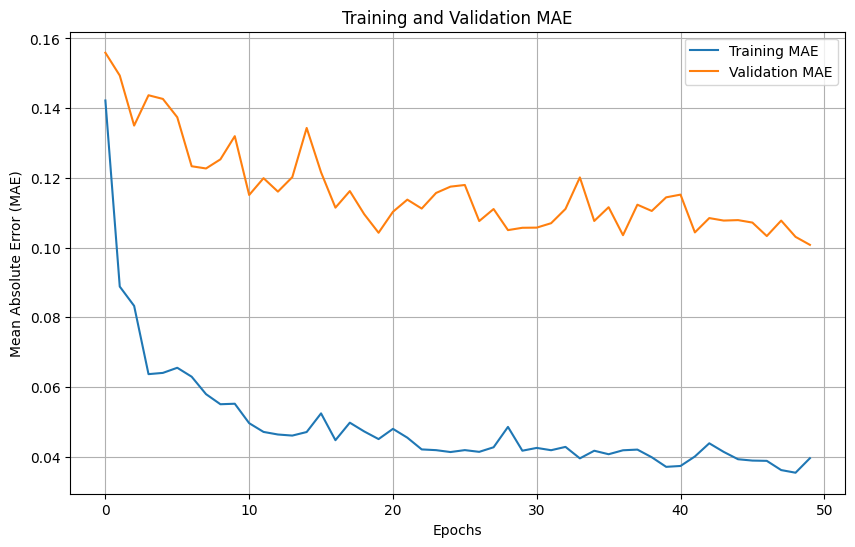

Training time: 1.2458216190338134 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0983 - mae: 0.2203
Test Loss: 0.09829485416412354
Test MAE: 0.22026312351226807


In [ ]:
train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               "concat_seq_data_att_lstm_256_NE",
                lstm_units=256)

X_train_seq shape: (552, 20, 21)
y_train_seq shape: (552, 1)
X_val_seq shape: (9, 20, 21)
y_val_seq shape: (9, 1)
X_test_seq shape: (18, 20, 21)
y_test_seq shape: (18, 1)
Creating new model...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 0.0477 - mae: 0.1693 - val_loss: 0.0215 - val_mae: 0.1259
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0219 - mae: 0.1076 - val_loss: 0.0456 - val_mae: 0.1800
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - loss: 0.0152 - mae: 0.0901 - val_loss: 0.0333 - val_mae: 0.1499
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.0143 - mae: 0.0845 - val_loss: 0.0244 - val_mae: 0.1468
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.0084 - mae: 0.0707 - val_loss: 0.0223 - val_mae: 0.1416
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - loss: 0.0065 - mae: 0.0618 - val_loss: 0.0187 - val_mae: 0.1267
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0059 - mae: 0.0587 - val_loss: 0.0210

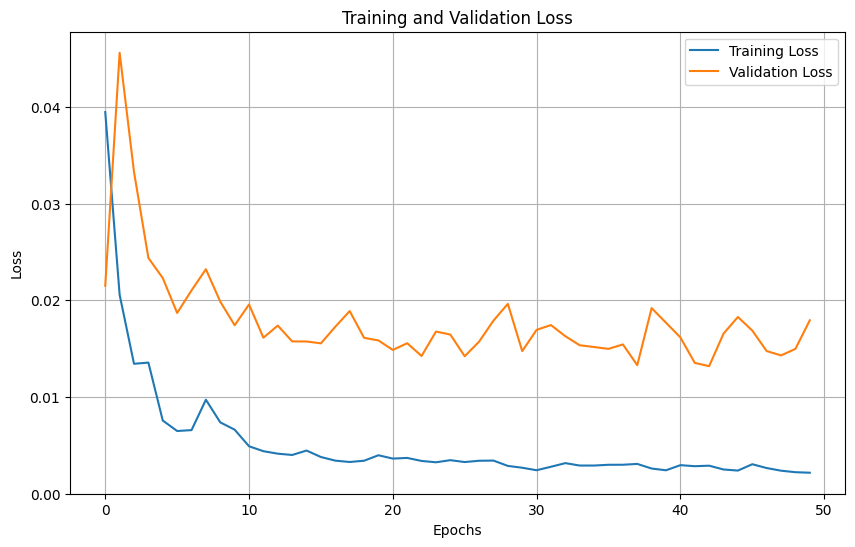

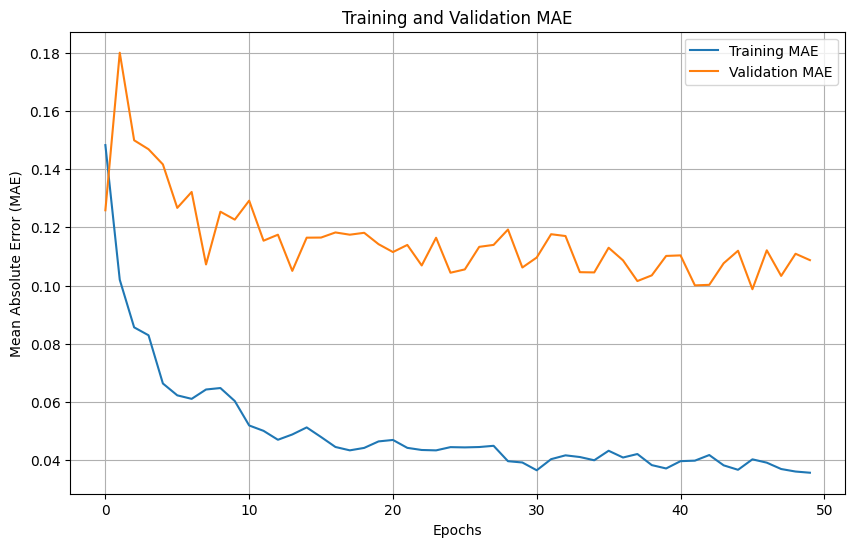

Training time: 3.9218108018239337 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1089 - mae: 0.2401
Test Loss: 0.10894179344177246
Test MAE: 0.24012655019760132


In [ ]:
train_loop(X_train, y_train,
               X_val, y_val,
               X_test, y_test,
               "concat_seq_data_att_lstm_512_NE",
                lstm_units=512)

In [ ]:
# load models

model_128_NE = tf.keras.models.load_model('/content/concat_seq_data_att_lstm_128_NE.keras')
model_256_NE = tf.keras.models.load_model('/content/concat_seq_data_att_lstm_256_NE.keras')
model_512_NE = tf.keras.models.load_model('/content/concat_seq_data_att_lstm_512_NE.keras')


# Evaluate them
print("Model 128")
evaluate_model_V2(model_128_NE, X_test, y_test)
print("Model 256")
evaluate_model_V2(model_256_NE, X_test, y_test)
print("Model 512")
evaluate_model_V2(model_512_NE, X_test, y_test)

Model 128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
R² - Attention_LSTM_Model: 0.274356841338681
MSE - Attention_LSTM_Model: 0.11469544924218827
RMSE - Attention_LSTM_Model: 0.3386671658755662
MAE - Attention_LSTM_Model: 0.2538122248568762
MAPE - Attention_LSTM_Model: 21.611404094975757
Model 256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
R² - Attention_LSTM_Model: 0.3781183958359523
MSE - Attention_LSTM_Model: 0.09829485624398858
RMSE - Attention_LSTM_Model: 0.31352010500761923
MAE - Attention_LSTM_Model: 0.2202631247411545
MAPE - Attention_LSTM_Model: 17.4047014967817
Model 512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
R² - Attention_LSTM_Model: 0.31075845022142334
MSE - Attention_LSTM_Model: 0.10894179631497419
RMSE - Attention_LSTM_Model: 0.3300633216747571
MAE - Attention_LSTM_Model: 0.24012654641455697
MAPE - Attention_LSTM_Model: 19.869917083229883


(0.31075845022142334,
 0.10894179631497419,
 0.3300633216747571,
 0.24012654641455697,
 19.869917083229883)

In [ ]:
# Rebuilding the corrected dataset based on the new image structure

data_updated = {
    "Dataset": ["Emotion"] * 6 + ["No emotion"] * 6,
    "Batch Size": [16, 16, 16, 30, 30, 30] * 2,
    "LSTM Units": [128, 256, 512, 128, 256, 512] * 2,
    "R^2": [
        0.1948, 0.3896, 0.3833, 0.4317, 0.4059, 0.3650,
        0.4500, 0.4392, 0.4170, 0.2744, 0.3781, 0.3108
    ],
    "MSE": [
        0.1272, 0.0964, 0.0975, 0.0898, 0.0938, 0.1004,
        0.0869, 0.0886, 0.0921, 0.1147, 0.0982, 0.1089
    ],
    "RMSE": [
        0.3567, 0.3106, 0.3122, 0.2997, 0.3064, 0.3168,
        0.2948, 0.2977, 0.3035, 0.3387, 0.3135, 0.3301
    ],
    "MAE": [
        0.2442, 0.2238, 0.2176, 0.2000, 0.2132, 0.2221,
        0.1954, 0.1992, 0.2152, 0.2538, 0.2203, 0.2401
    ],
    "MAPE": [
        18.7784, 19.0448, 17.0933, 15.2419, 16.9462, 17.7219,
        15.0891, 15.1818, 17.4985, 21.6114, 17.4047, 19.8699
    ],
}

# Convert the updated data dictionary into a Pandas DataFrame
df_updated = pd.DataFrame(data_updated)

# Displaying the structure of the DataFrame to ensure it is accurate
df_updated


,Dataset,Batch Size,LSTM Units,R^2,MSE,RMSE,MAE,MAPE
0,Emotion,16,128,0.1948,0.1272,0.3567,0.2442,18.7784
1,Emotion,16,256,0.3896,0.0964,0.3106,0.2238,19.0448
2,Emotion,16,512,0.3833,0.0975,0.3122,0.2176,17.0933
3,Emotion,30,128,0.4317,0.0898,0.2997,0.2000,15.2419
4,Emotion,30,256,0.4059,0.0938,0.3064,0.2132,16.9462
5,Emotion,30,512,0.3650,0.1004,0.3168,0.2221,17.7219
6,No emotion,16,128,0.4500,0.0869,0.2948,0.1954,15.0891
7,No emotion,16,256,0.4392,0.0886,0.2977,0.1992,15.1818
8,No emotion,16,512,0.4170,0.0921,0.3035,0.2152,17.4985
9,No emotion,30,128,0.2744,0.1147,0.3387,0.2538,21.6114


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_updated)

https://docs.google.com/spreadsheets/d/1VYpVd3TMggHuJUPBCPwP8dllwSeFisjTweH5jwOPVzo#gid=0


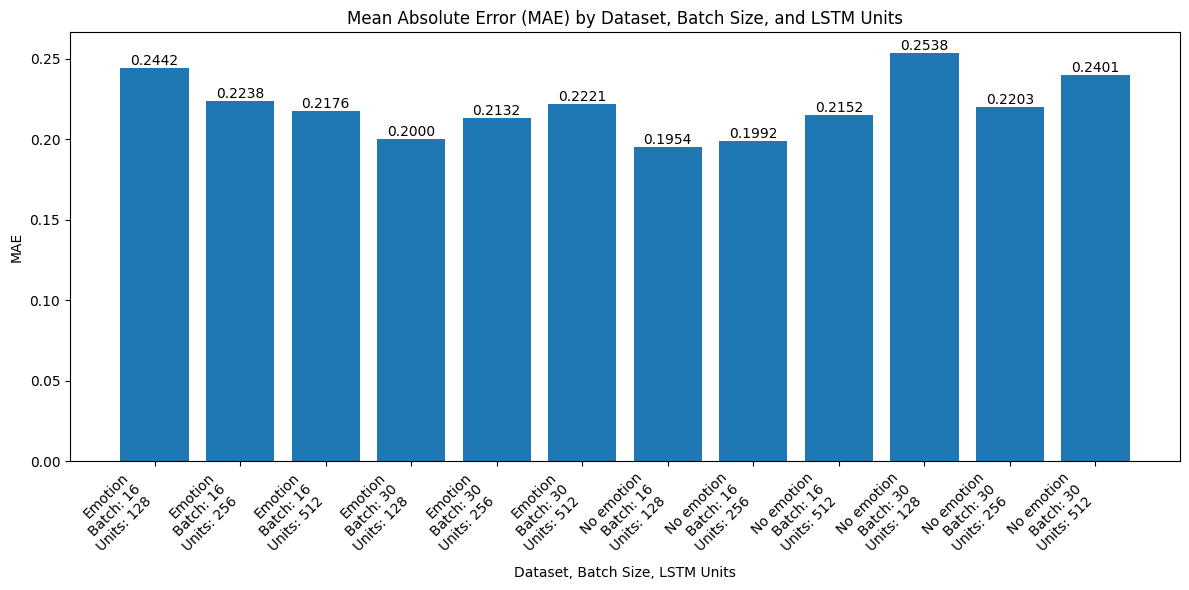

In [ ]:
# prompt: do a bar plot with values on top of the bar with 4 numbers after the . of the MAE  score in the df_updated grouped by dataset, batch size, LSTM_units. use the dataset, batch size, LSTM_units for labeling.

import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_updated is already defined as in your provided code

# Group the data and calculate the mean MAE for each group
grouped_mae = df_updated.groupby(['Dataset', 'Batch Size', 'LSTM Units'])['MAE'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(grouped_mae)), grouped_mae['MAE'])

# Add MAE values on top of each bar with 4 decimal places
for bar, value in zip(bars, grouped_mae['MAE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.4f}', ha='center', va='bottom')

# Customize the x-axis labels
plt.xticks(range(len(grouped_mae)), [f"{row['Dataset']}\nBatch: {row['Batch Size']}\nUnits: {row['LSTM Units']}" for _, row in grouped_mae.iterrows()], rotation=45, ha="right")

plt.xlabel('Dataset, Batch Size, LSTM Units')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) by Dataset, Batch Size, and LSTM Units')
plt.tight_layout()
plt.show()